In [1]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Reshape,MaxPooling2D, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import seaborn as sns
from tensorflow.keras.layers import Layer
tf.keras.mixed_precision.set_global_policy('mixed_float16')
from keras.optimizers import Adam

2024-10-10 10:39:00.395852: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 10:39:00.395960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 10:39:00.528141: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Tạo chiến lược MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

print('Số lượng thiết bị được sử dụng:', strategy.num_replicas_in_sync)

Số lượng thiết bị được sử dụng: 2


# Loading and Preprocessing

In [3]:
base_path = '/kaggle/input/asvpoof-2019-dataset/LA/LA'
protocol_dir = os.path.join(base_path, 'ASVspoof2019_LA_cm_protocols')
train_dir = os.path.join(base_path, 'ASVspoof2019_LA_train', 'flac')
dev_dir = os.path.join(base_path, 'ASVspoof2019_LA_dev', 'flac')
eval_dir = os.path.join(base_path, 'ASVspoof2019_LA_eval', 'flac')

In [4]:
def get_file_path(directory, filename):
    return os.path.join(directory, f'{filename}.flac')

In [5]:
def read_dataset(protocol_path, directory):
    """Reads the dataset from a protocol file and returns a DataFrame."""
    df = pd.read_csv(protocol_path, sep=' ', header=None, names=['speaker_id', 'filename', 'system_id', 'null', 'class_name'])
    df['filepath'] = df['filename'].apply(lambda x: get_file_path(directory, x))
    df.drop('null', axis=1, inplace=True)
    df.dropna(inplace=True)
    return df

def label_to_int(class_name):
    if class_name == 'bonafide':
        return 0
    else:
        return 1

def add_columns(df, subset):
    df['target'] = df['class_name'].apply(label_to_int)
    df['subset'] = subset
    return df

def sample_data(df, n_bonafide, n_spoof):
    bonafide = df[df['class_name'] == 'bonafide'].head(n_bonafide)
    spoof = df[df['class_name'] != 'bonafide'].head(n_spoof)
    return pd.concat([bonafide, spoof])

In [6]:
train_df = read_dataset(os.path.join(protocol_dir, 'ASVspoof2019.LA.cm.train.trn.txt'), train_dir)
dev_df = read_dataset(os.path.join(protocol_dir, 'ASVspoof2019.LA.cm.dev.trl.txt'), dev_dir)
eval_df = read_dataset(os.path.join(protocol_dir, 'ASVspoof2019.LA.cm.eval.trl.txt'), eval_dir)

train_df = add_columns(train_df, 'train')
dev_df = add_columns(dev_df, 'dev')
eval_df = add_columns(eval_df, 'eval')

In [7]:
data_df = pd.concat([train_df, dev_df, eval_df], ignore_index=True)
data_df

,speaker_id,filename,system_id,class_name,filepath,target,subset
0,LA_0079,LA_T_1138215,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0,train
1,LA_0079,LA_T_1271820,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0,train
2,LA_0079,LA_T_1272637,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0,train
3,LA_0079,LA_T_1276960,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0,train
4,LA_0079,LA_T_1341447,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0,train
...,...,...,...,...,...,...,...
121456,LA_0004,LA_E_1665632,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0,eval
121457,LA_0038,LA_E_5085671,-,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,1,eval
121458,LA_0012,LA_E_4926022,-,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,1,eval
121459,LA_0052,LA_E_2894498,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0,eval


In [8]:
data_df[data_df['subset'] == 'eval'].index[0]

50224

In [9]:
num_train = (data_df['subset'] == 'train').sum()
num_valid = data_df[data_df['subset'] == 'dev'].index[-1]+1
num_test = data_df[data_df['subset'] == 'eval'].index[0]

In [10]:
X = np.load('/kaggle/input/feature-la-asvspoof2019/feature_LA.npy')

In [11]:
X[:,:,:,0] = X[:,:,:,0]/X[:,:,:,0].max()
X[:,:,:,1] = X[:,:,:,1]/X[:,:,:,1].max()
X[:,:,:,2] = X[:,:,:,2]/X[:,:,:,2].max()

In [12]:
xtrain = X[0:num_train]
ytrain = data_df[data_df['subset'] == 'train']['target']
xvalid = X[num_train:num_valid]
yvalid = data_df[data_df['subset'] == 'dev']['target']
xtest = X[num_valid:]
ytest = data_df[data_df['subset'] == 'eval']['target']
print('shape of x_train, y_train, x_valid, y_valid, x_test, y_test:', 
      xtrain.shape, ytrain.shape, xvalid.shape, yvalid.shape, xtest.shape, ytest.shape, sep='\n')

shape of x_train, y_train, x_valid, y_valid, x_test, y_test:
(25380, 70, 70, 3)
(25380,)
(24844, 70, 70, 3)
(24844,)
(71237, 70, 70, 3)
(71237,)


# Evalution

In [18]:
def plot_eer(ytest, ypred):
    # Calculate False Positive Rate and True Positive Rate
    fpr, tpr, thresholds = roc_curve(ytest, ypred)
    
    # Calculate False Acceptance Rate and False Rejection Rate
    far = fpr
    frr = 1 - tpr
    
    # Find the threshold closest to where FAR and FRR are equal
    eer_index = np.nanargmin(np.absolute((far - frr)))
    eer_threshold = thresholds[eer_index]
    eer = far[eer_index]
    
    # Plot FAR, FRR and the difference between FAR and FRR
    plt.figure(figsize=(10, 5))
    plt.plot(far, label="FAR")
    plt.plot(frr, label="FRR")
    plt.plot(far - frr, label="FAR - FRR")
    plt.axhline(y=eer, color='r', linestyle='--', label=f'EER = {eer*100:.2f} %')
    plt.axvline(x=eer_index, color='g', linestyle='--', label=f'Threshold = {eer_threshold:.2f}')
    plt.title('ROC Curve and EER Calculation')
    plt.xlabel('Threshold Index')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return eer

from scipy.interpolate import make_interp_spline
def plot_training_history(history):
    # Số lượng điểm dữ liệu (epochs)
    epochs = len(history.history['accuracy'])
    
    # Check if there are enough epochs to use cubic spline interpolation
    if epochs > 3:
        xnew = np.linspace(0, epochs - 1, 300)  # Tạo thêm điểm dữ liệu để làm mịn đường
        
        # Tính toán spline cho accuracy
        spl_acc = make_interp_spline(range(epochs), history.history['accuracy'], k=3)
        smooth_acc = spl_acc(xnew)
        spl_val_acc = make_interp_spline(range(epochs), history.history['val_accuracy'], k=3)
        smooth_val_acc = spl_val_acc(xnew)

        # Tính toán spline cho loss
        spl_loss = make_interp_spline(range(epochs), history.history['loss'], k=3)
        smooth_loss = spl_loss(xnew)
        spl_val_loss = make_interp_spline(range(epochs), history.history['val_loss'], k=3)
        smooth_val_loss = spl_val_loss(xnew)
    else:
        # Fallback to linear interpolation if not enough data for cubic spline
        xnew = np.linspace(0, epochs - 1, epochs)
        smooth_acc = history.history['accuracy']
        smooth_val_acc = history.history['val_accuracy']
        smooth_loss = history.history['loss']
        smooth_val_loss = history.history['val_loss']

    # Vẽ biểu đồ accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(xnew, smooth_acc, label='Train')
    plt.plot(xnew, smooth_val_acc, label='Test')
    plt.scatter(range(epochs), history.history['accuracy'], color='blue', s=20)  # Thêm chấm cho mỗi epoch
    plt.scatter(range(epochs), history.history['val_accuracy'], color='orange', s=20)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Vẽ biểu đồ loss
    plt.subplot(1, 2, 2)
    plt.plot(xnew, smooth_loss, label='Train')
    plt.plot(xnew, smooth_val_loss, label='Test')
    plt.scatter(range(epochs), history.history['loss'], color='blue', s=20)  # Thêm chấm cho mỗi epoch
    plt.scatter(range(epochs), history.history['val_loss'], color='orange', s=20)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.tight_layout()
    plt.show()

    
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes=2, normalize=False, cmap=plt.cm.Blues):
    y_pred = y_pred.reshape(-1).round()
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'

    # Plotting
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=classes, yticklabels=classes, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'CM, Acc:{accuracy_score(y_true, y_pred)*100:.2f}%')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()
    
    
def predict_in_batches(model, data, batch_size=20000):
    number_of_batches = data.shape[0] // batch_size + 1  # Calculate how many batches are needed
    predictions = []

    for batch in range(number_of_batches):
        start = batch * batch_size
        end = start + batch_size
        batch_predictions = model.predict(data[start:end])
        predictions.append(batch_predictions)
        
    return np.concatenate(predictions, axis=0).reshape(-1).round()


def calculate_tdcf(ytest, ypred, Cmiss_spoof=10, Cfa_spoof=1, Cmiss=1, Cfa=1):
    Ptar = np.mean(ytest == 0)
    Pspoof = np.mean(ytest == 1)
    Pnon = 0  # Không có người dùng không hợp lệ trong dữ liệu này
    
    Pmiss_spoof = np.mean((ytest == 1) & (ypred == 0))
    Pfa_spoof = np.mean((ytest == 0) & (ypred == 1))
    
    # Tính các hệ số chi phí cho T-DCF
    C1 = Cmiss
    C2 = Cfa
    C3 = Cfa_spoof * Cmiss_spoof + (1 - Cfa_spoof) * Cmiss
    C4 = Pmiss_spoof * Cfa_spoof + (1 - Pmiss_spoof) * Cfa

    # Tính T-DCF
    TDCF = min(
        C1 * Pmiss_spoof * Ptar,  # Pmiss không áp dụng vì không có Pnon
        C2 * Pfa_spoof * Pnon + C3 * Pmiss_spoof * Pspoof + C4 * Pfa_spoof * Ptar
    )
    return TDCF

In [19]:
 def predict_in_batches_(model, data, batch_size=20000):
    number_of_batches = data.shape[0] // batch_size + 1  # Calculate how many batches are needed
    predictions = []

    for batch in range(number_of_batches):
        start = batch * batch_size
        end = start + batch_size
        batch_predictions = model.predict(data[start:end])
        predictions.append(batch_predictions)
        
    return np.concatenate(predictions, axis=0).reshape(-1)

 
def find_best_ensemble_weights(model1, model2, X_test, y_test, num_iterations=10):
    results = []
    
    for i in range(num_iterations):
        # Khởi tạo trọng số ngẫu nhiên cho model1 trong khoảng [0, 1]
        weight1 = 0.1 + i/num_iterations
        weight2 = 1 - weight1  # Đảm bảo tổng trọng số bằng 1
    
        # Dự đoán với hai mô hình
        pred1 = predict_in_batches_(model1, X_test)
        pred2 = predict_in_batches_(model2, X_test)
    
        # Kết hợp dự đoán với trọng số
        ensemble_pred = (weight1 * pred1) + (weight2 * pred2)
    
        # Giả sử bài toán là phân loại nhị phân
        final_pred = ensemble_pred.round()
    
        # Tính độ chính xác
        accuracy = accuracy_score(y_test, final_pred)
    
        # Lưu kết quả
        results.append({
            'weight1': weight1,
            'weight2': weight2,
            'accuracy': accuracy
        })
        print(f'Step {i+1}/{num_iterations}: Weight1={weight1:.4f}, Weight2={weight2:.4f}, Accuracy={accuracy:.4f}')
        plot_eer(y_test, final_pred)
    
    # Tìm bộ trọng số có độ chính xác cao nhất
    best_result = max(results, key=lambda x: x['accuracy'])
    print(f"\nBest Weights: Model1: {best_result['weight1']:.4f}, Model2: {best_result['weight2']:.4f}")
    print(f"Best Accuracy: {best_result['accuracy'] * 100:.2f}%")
    
    return best_result['weight1'], best_result['weight2'], best_result['accuracy'], results

# Call Back

In [14]:
class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, patience=5, delta=0.001, max_acc = 0.99):
        super(myCallback, self).__init__()
        self.patience = patience
        self.delta = delta
        self.wait = 0
        self.best_val_acc = -float('inf')
        self.max_acc = max_acc

    def on_epoch_end(self, epoch, logs={}):
        current_val_acc = logs.get('val_accuracy')
        if current_val_acc is None:
            return

        if current_val_acc > self.best_val_acc + self.delta:
            self.best_val_acc = current_val_acc
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
                print("\nTraining stopped as val_accuracy did not improve for {} epochs.".format(self.patience))
            
        if logs.get('val_accuracy') >=  self.max_acc and logs.get('accuracy') >=  self.max_acc:
            self.model.stop_training = True

# ConvNext

In [17]:
def ConvNeXt_block(dim, kernel_size=7):
    def layer(x):
        # Layer normalization inside the convolution block
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        
        # Depthwise convolution
        x = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=1, padding="same", use_bias=False)(x)
        
        # Pointwise convolution to mix channels
        x = layers.Conv2D(dim, kernel_size=1, strides=1, use_bias=False)(x)
        x = layers.Activation("gelu")(x)  # Using GELU activation as per original architecture
        
        return x
    return layer

def build_convnext_model(input_shape, num_classes, num_blocks=4, dim=96):
    inputs = layers.Input(shape=input_shape)

    # Initial convolution layer
    x = layers.Conv2D(dim, kernel_size=4, strides=4, padding="same")(inputs)

    # Stacking ConvNeXt blocks
    for _ in range(num_blocks):
        x = ConvNeXt_block(dim)(x)

    # Final layers and classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='gelu')(x)  # Large dense layer before classification
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    # Create the Keras model
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

# RestNeSt

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models

def split_attention_block(filters, cardinality, reduction_factor=16, adjust_residual=False):
    def block(x):
        # Residual path
        residual = x

        # Adjusting the residual path if the number of filters changes
        if adjust_residual:
            residual = layers.Conv2D(filters, kernel_size=1, strides=1, padding='same')(residual)
            residual = layers.BatchNormalization()(residual)

        # Grouped convolutions
        grouped = layers.Conv2D(filters * 2, kernel_size=1, groups=cardinality, padding='same')(x)
        grouped = layers.BatchNormalization()(grouped)
        grouped = layers.Activation('relu')(grouped)

        # Channel-wise attention via global average pooling and dense layers
        gap = layers.GlobalAveragePooling2D()(grouped)
        gap = layers.Dense(filters * 2 // reduction_factor, activation='relu')(gap)
        gap = layers.Dense(filters * 2)(gap)
        attention = layers.Reshape((1, 1, filters * 2))(gap)
        attention = layers.Activation('sigmoid')(attention)
        
        # Attention applied
        reduced = layers.Multiply()([grouped, attention])

        # Merging blocks
        reduced = layers.Conv2D(filters, kernel_size=1)(reduced)
        reduced = layers.BatchNormalization()(reduced)
        
        # Adding residual
        return layers.Add()([residual, reduced])
    return block

def build_resnest(input_shape, num_classes, dim=96):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(dim, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.DepthwiseConv2D(kernel_size=7, strides=1, padding="same", use_bias=False)(x)
    x = layers.Conv2D(dim, kernel_size=1, strides=1, use_bias=False)(x)
    # Using the split-attention block with adjustment
    x = split_attention_block(filters=dim, cardinality=1)(x) 
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

Epoch 1/200
 21/794 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7277 - loss: 0.6216 

I0000 00:00:1728233676.375683     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


794/794 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.9206 - loss: 0.2149 - val_accuracy: 0.9879 - val_loss: 0.0445
Epoch 2/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9894 - loss: 0.0344 - val_accuracy: 0.9828 - val_loss: 0.0455
Epoch 3/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9956 - loss: 0.0151 - val_accuracy: 0.9957 - val_loss: 0.0146
Epoch 4/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9977 - loss: 0.0084 - val_accuracy: 0.9936 - val_loss: 0.0185
Epoch 5/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9990 - loss: 0.0045 - val_accuracy: 0.9936 - val_loss: 0.0189
Epoch 6/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9973 - loss: 0.0077 - val_accuracy: 0.9866 - val_loss: 0.0341
Epoch 7/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9988 - loss: 0.0037 - val_accuracy: 0.9705 - val_loss: 0.0844
Epoch 8/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9987 - loss: 0.0044 - val_accuracy: 0.99

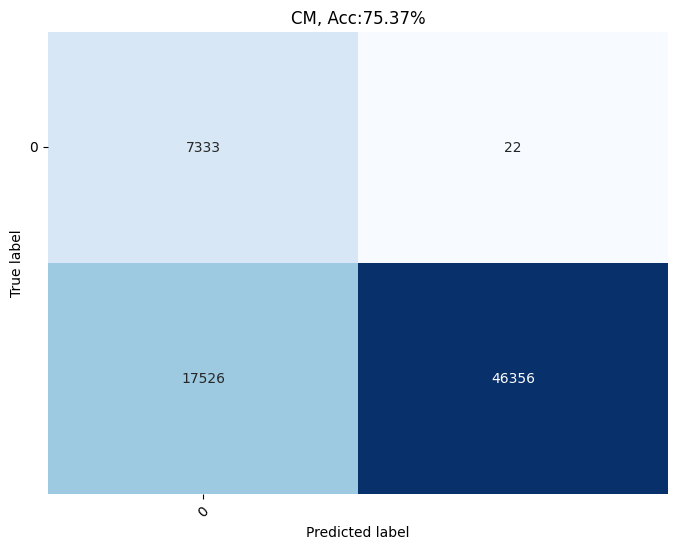

777/777 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


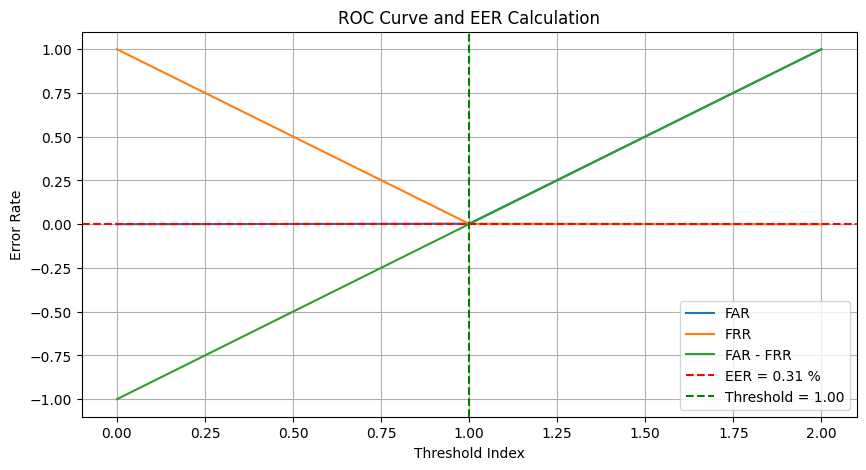

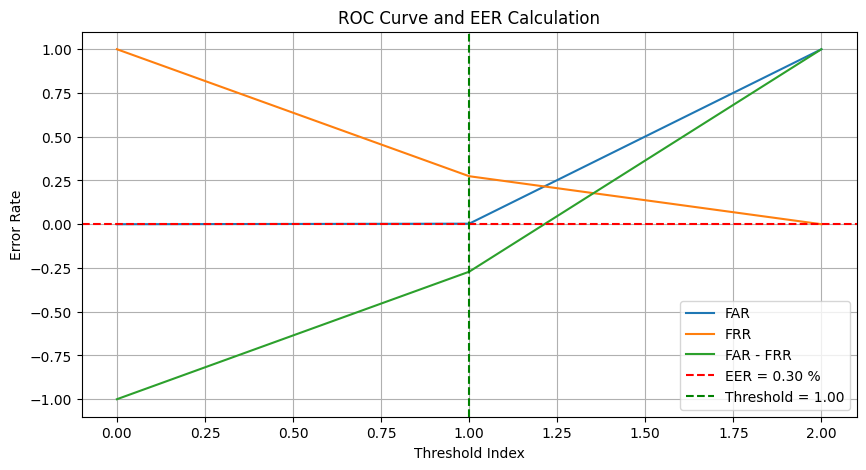

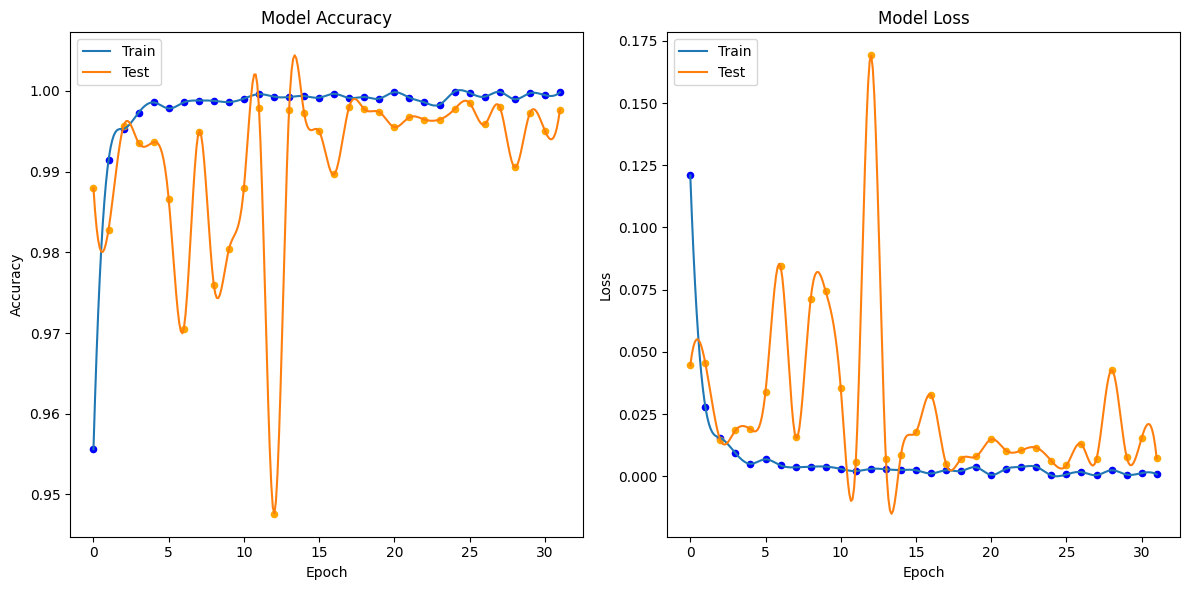

0.025401200404988097

In [18]:
# Specify input shape and number of classes
input_shape = (70,70,3)
num_classes = 1

# Build and compile the model
# with strategy.scope():
restnest_model = build_resnest(input_shape, num_classes, dim=128)
restnest_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
callback_0 = myCallback(patience=20, max_acc=1)
history_0 = restnest_model.fit(xtrain, ytrain, 
          epochs=200,
          validation_data=[xvalid,yvalid],
          callbacks=callback_0)
ypred_0 = predict_in_batches(restnest_model, xtest)
plot_confusion_matrix(ytest, ypred_0)
plot_eer(yvalid, restnest_model.predict(xvalid).reshape(-1).round())
plot_eer(ytest, ypred_0)
plot_training_history(history_0)

In [27]:
calculate_tdcf(ytest, ypred_0) 

0.019866156222251047

# ConvNeXt

Epoch 1/200
 16/794 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8647 - loss: 0.5076   

I0000 00:00:1728313194.600999     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


794/794 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - accuracy: 0.9209 - loss: 0.2463 - val_accuracy: 0.9961 - val_loss: 0.0132
Epoch 2/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9923 - loss: 0.0217 - val_accuracy: 0.9966 - val_loss: 0.0121
Epoch 3/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9956 - loss: 0.0128 - val_accuracy: 0.9819 - val_loss: 0.0485
Epoch 4/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9965 - loss: 0.0106 - val_accuracy: 0.9977 - val_loss: 0.0079
Epoch 5/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9980 - loss: 0.0064 - val_accuracy: 0.9977 - val_loss: 0.0069
Epoch 6/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9983 - loss: 0.0055 - val_accuracy: 0.9977 - val_loss: 0.0094
Epoch 7/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9982 - loss: 0.0051 - val_accuracy: 0.9978 - val_loss: 0.0120
Epoch 8/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9993 - loss: 0.0022 - val_accuracy: 0.9

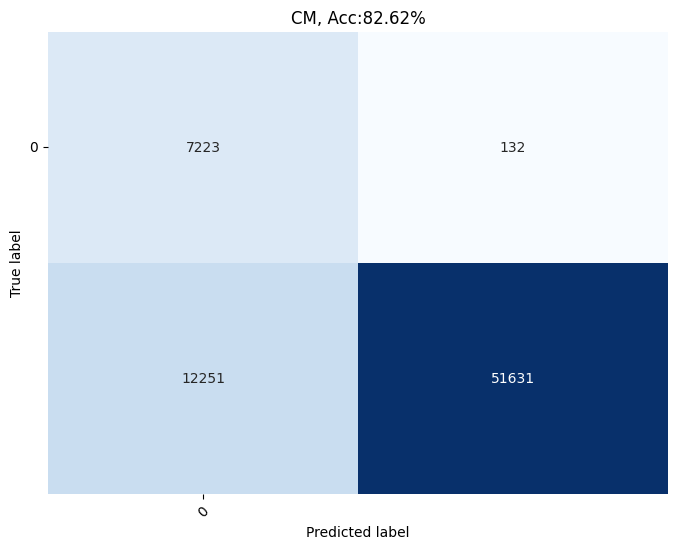

777/777 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


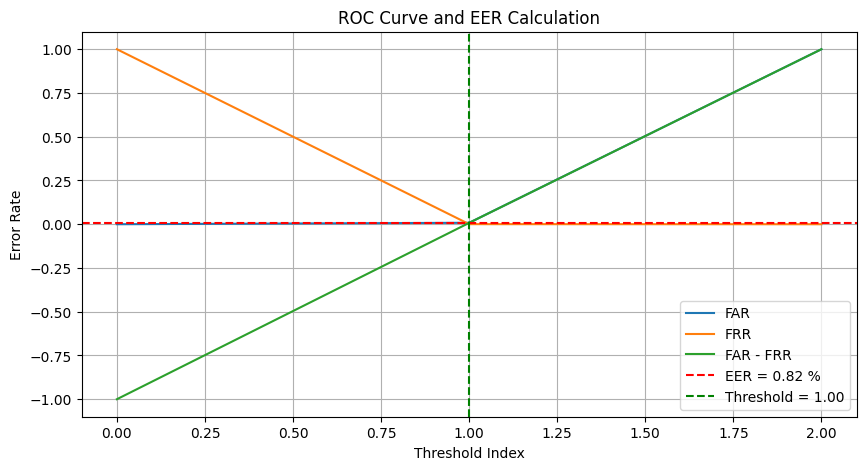

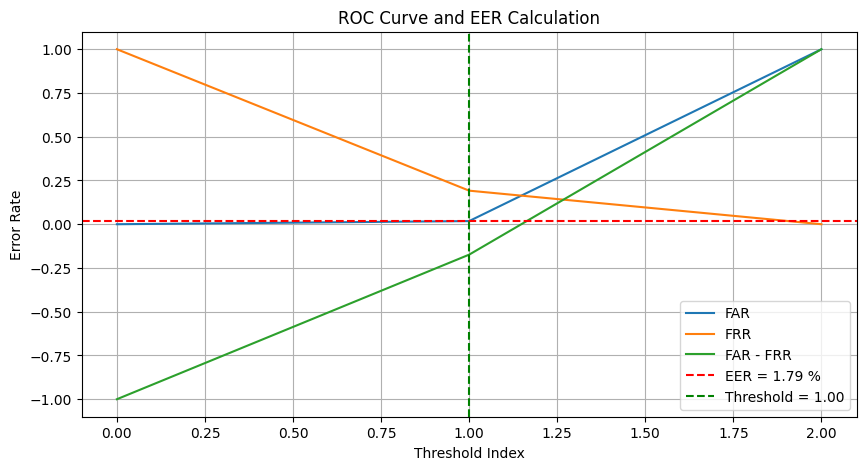

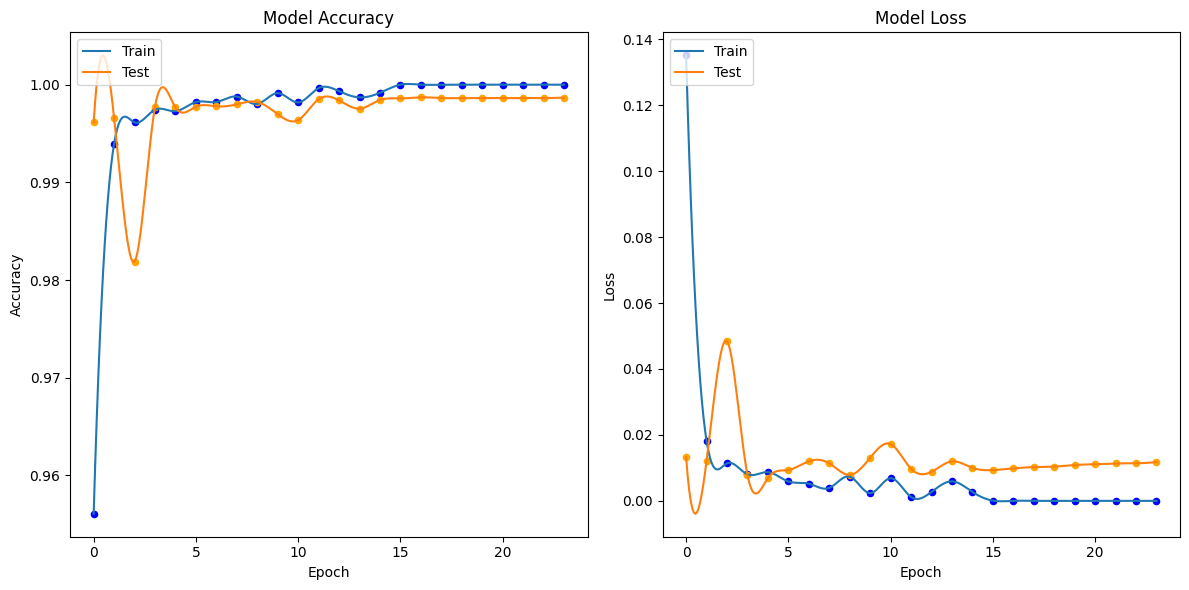

In [18]:
# Model parameters
input_shape = (70, 70, 3)
num_classes = 1

convnext_model = build_convnext_model(input_shape, num_classes)
convnext_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

callback_1 = myCallback(patience=20,max_acc=1)
history_1 = convnext_model.fit(xtrain, ytrain, 
          epochs=200,
          validation_data=[xvalid,yvalid],
          callbacks=callback_1 ,batch_size=32, validation_batch_size=32)
ypred_1 = predict_in_batches(convnext_model, xtest)
plot_confusion_matrix(ytest, ypred_1)
plot_eer(yvalid, convnext_model.predict(xvalid).reshape(-1).round())
plot_eer(ytest, ypred_1)
plot_training_history(history_1)

In [19]:
calculate_tdcf(ytest, ypred_1) 

0.01775591156918345

Epoch 1/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.9024 - loss: 0.3006 - val_accuracy: 0.9866 - val_loss: 0.0408
Epoch 2/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9909 - loss: 0.0291 - val_accuracy: 0.9919 - val_loss: 0.0248
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


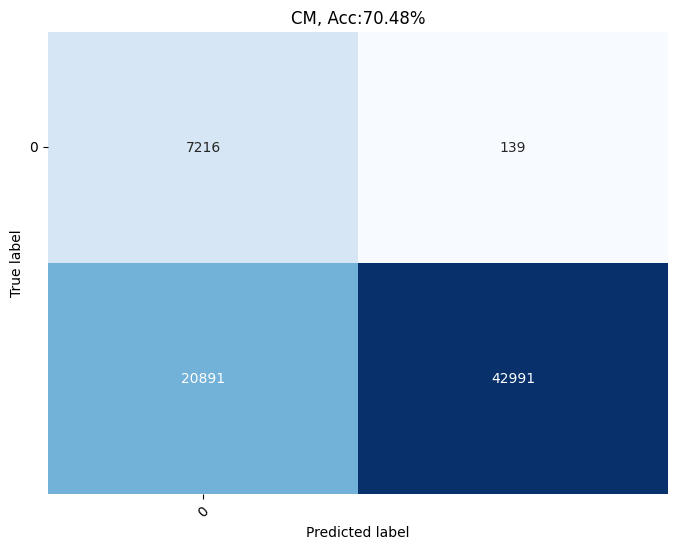

777/777 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


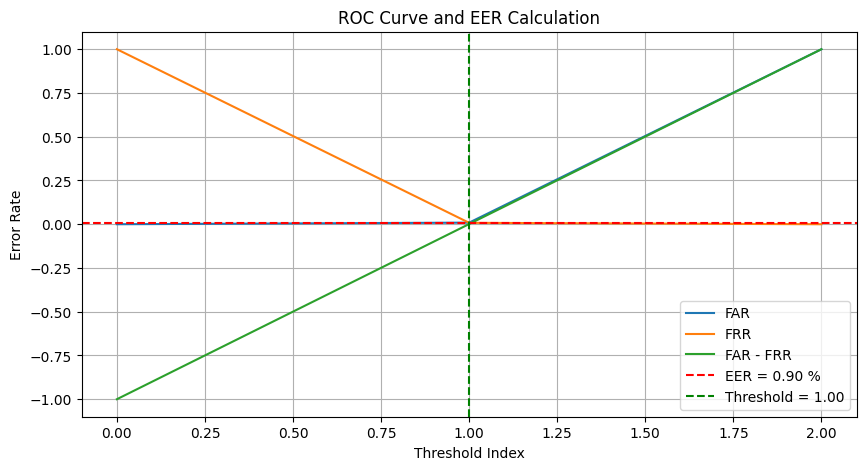

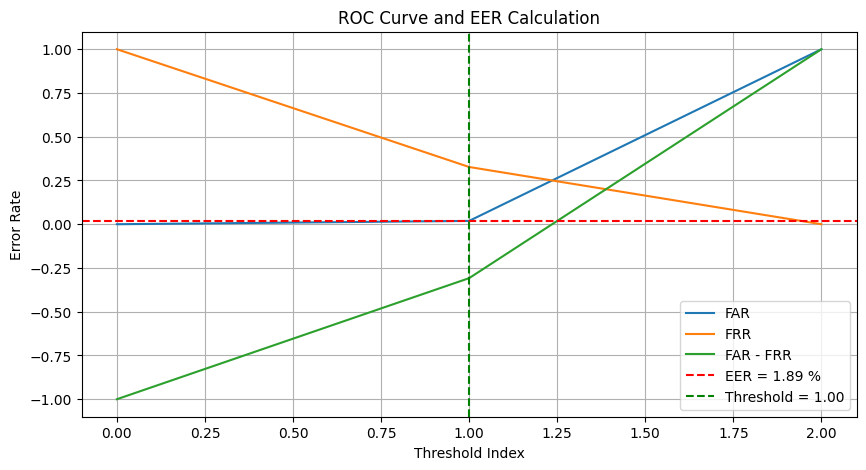

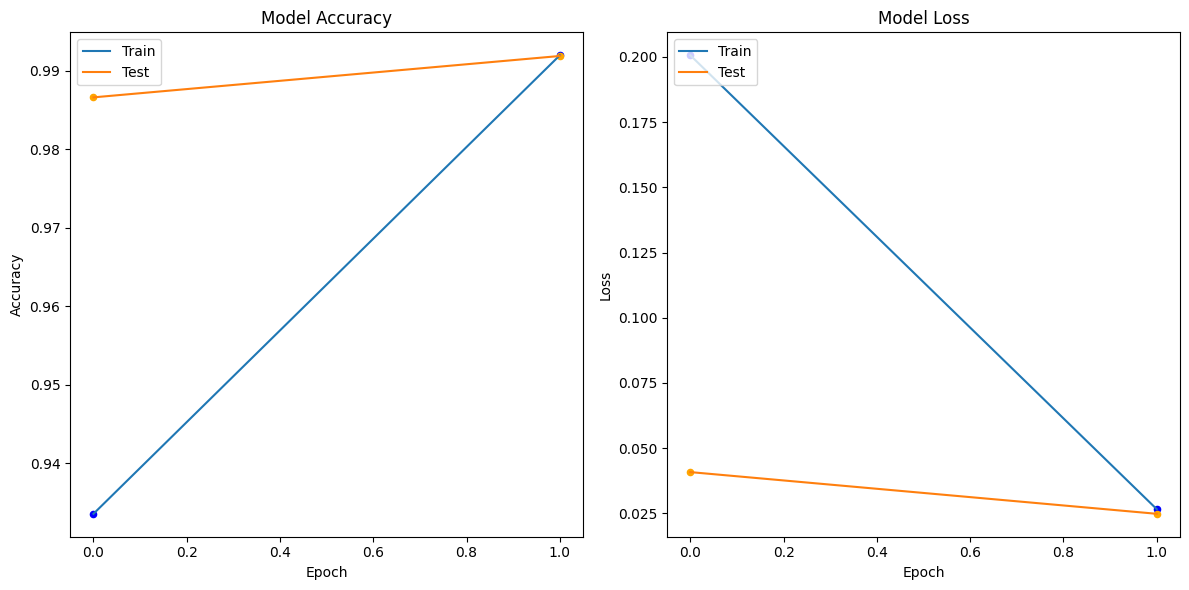

In [20]:
# Model parameters
input_shape = (70, 70, 3)
num_classes = 1

convnext_model = build_convnext_model(input_shape, num_classes)
convnext_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

callback_1 = myCallback(patience=20)
history_1 = convnext_model.fit(xtrain, ytrain, 
          epochs=200,
          validation_data=[xvalid,yvalid],
          callbacks=callback_1 ,batch_size=32, validation_batch_size=32)
ypred_1 = predict_in_batches(convnext_model, xtest)
plot_confusion_matrix(ytest, ypred_1)
plot_eer(yvalid, convnext_model.predict(xvalid).reshape(-1).round())
plot_eer(ytest, ypred_1)
plot_training_history(history_1)

# RegNet

In [25]:
import tensorflow as tf
from keras import layers, models

def regnet_block(filters, stride=1, group_width=1):
    """A basic RegNet block."""
    def layer(input_tensor):
        # Grouped convolution
        x = layers.Conv2D(filters, kernel_size=3, padding='same', strides=stride,
                          groups=filters // group_width)(input_tensor)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        # SE block (Squeeze-and-Excitation block)
        se = layers.GlobalAveragePooling2D()(x)
        se = layers.Reshape((1, 1, filters))(se)
        se = layers.Conv2D(filters // 16, 1, activation='relu')(se)
        se = layers.Conv2D(filters, 1, activation='sigmoid')(se)
        x = layers.multiply([x, se])

        x = layers.Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        
        # Adding the input value back to the output
        if input_tensor.shape[-1] == filters and stride == 1:
            x = layers.add([x, input_tensor])
        x = layers.ReLU()(x)
        return x
    return layer

def build_regnet(input_shape, num_classes, num_blocks=4, filters=32):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(filters, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Stack of RegNet blocks
    for _ in range(num_blocks):
        x = regnet_block(filters)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

Epoch 1/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 43s 30ms/step - accuracy: 0.9458 - loss: 0.1412 - val_accuracy: 0.8980 - val_loss: 0.8888
Epoch 2/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9946 - loss: 0.0165 - val_accuracy: 0.9372 - val_loss: 0.2975
Epoch 3/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9956 - loss: 0.0131 - val_accuracy: 0.9942 - val_loss: 0.0170
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


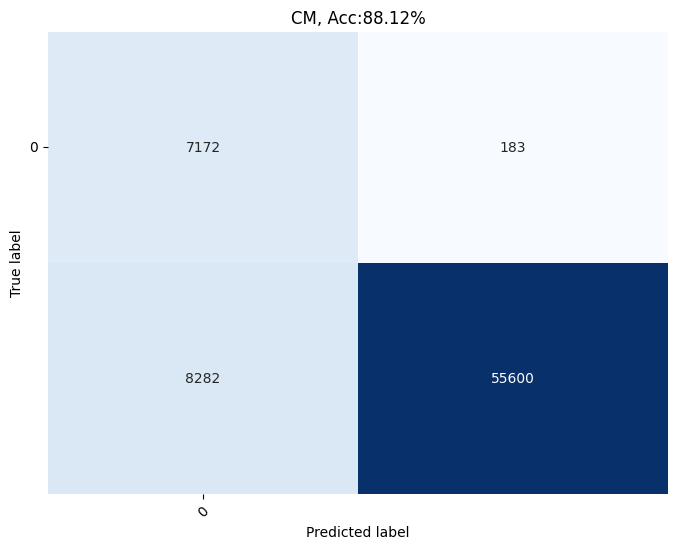

777/777 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


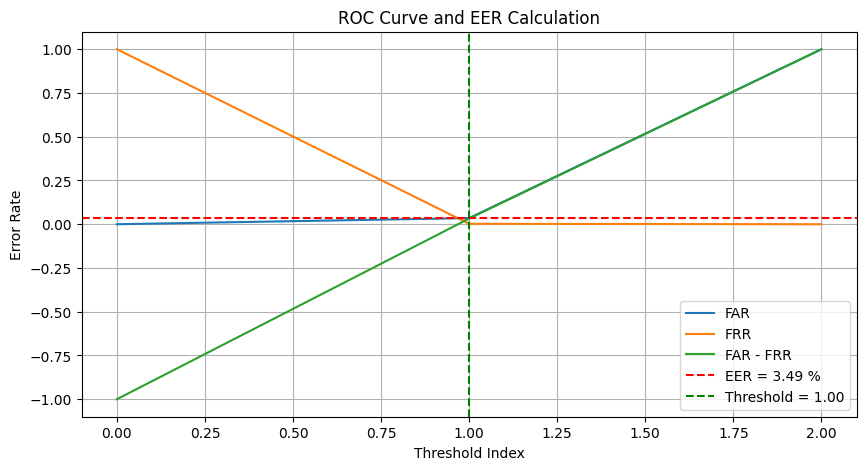

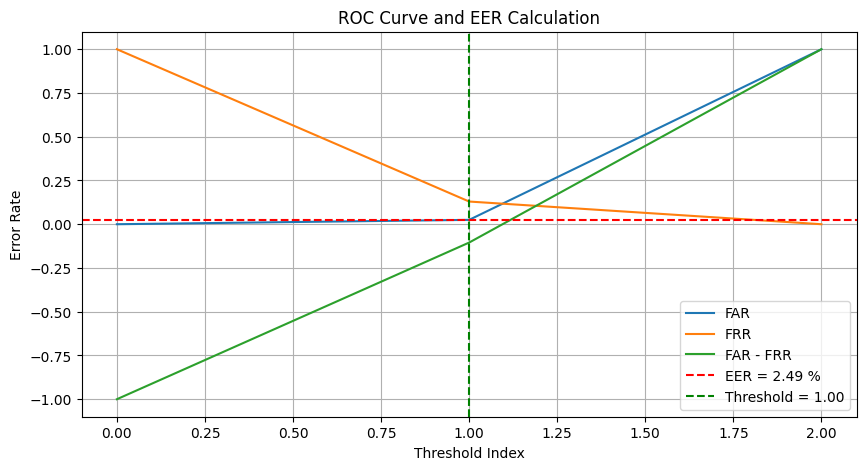

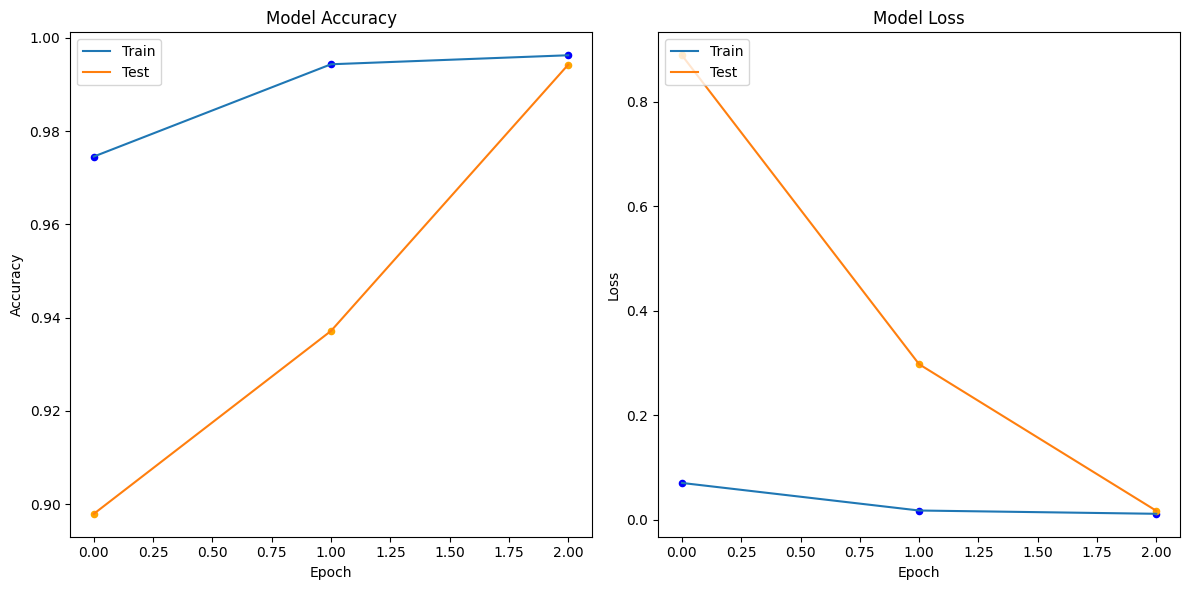

In [26]:
# Parameters
input_shape = (70, 70, 3)
num_classes = 1

# Create and compile the model
regnet_model = build_regnet(input_shape, num_classes)
regnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callback_2 = myCallback(patience=20)
history_2 = regnet_model.fit(xtrain, ytrain, 
          epochs=200,
          validation_data=[xvalid,yvalid],
          callbacks=callback_2)
ypred_2 = predict_in_batches(regnet_model, xtest)
plot_confusion_matrix(ytest, ypred_2)
plot_eer(yvalid, regnet_model.predict(xvalid).reshape(-1).round())
plot_eer(ytest, ypred_2)
plot_training_history(history_2)

In [28]:
calculate_tdcf(ytest, ypred_2) 

0.012003465808177073

In [ ]:
# Parameters
input_shape = (70, 70, 3)
num_classes = 1

# Create and compile the model
regnet_model = build_regnet(input_shape, num_classes, num_blocks=10)
regnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callback_2 = myCallback(patience=20, max_acc=1)
history_2 = regnet_model.fit(xtrain, ytrain, 
          epochs=200,
          validation_data=[xvalid,yvalid],
          callbacks=callback_2)
ypred_2 = predict_in_batches(regnet_model, xtest)
plot_confusion_matrix(ytest, ypred_2)
plot_eer(yvalid, regnet_model.predict(xvalid).reshape(-1).round())
plot_eer(ytest, ypred_2)
plot_training_history(history_2)

# ResneSt + ConvNeXt

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def split_attention_block(filters, cardinality, reduction_factor=16, adjust_residual=False):
    def block(x):
        # Residual path
        residual = x

        # Adjusting the residual path if the number of filters changes
        if adjust_residual:
            residual = layers.Conv2D(filters, kernel_size=1, strides=1, padding='same')(residual)
            residual = layers.BatchNormalization()(residual)

        # Grouped convolutions
        grouped = layers.Conv2D(filters * 2, kernel_size=1, groups=cardinality, padding='same')(x)
        grouped = layers.BatchNormalization()(grouped)
        grouped = layers.Activation('relu')(grouped)

        # Channel-wise attention via global average pooling and dense layers
        gap = layers.GlobalAveragePooling2D()(grouped)
        gap = layers.Dense(filters * 2 // reduction_factor, activation='relu')(gap)
        gap = layers.Dense(filters * 2)(gap)
        attention = layers.Reshape((1, 1, filters * 2))(gap)
        attention = layers.Activation('sigmoid')(attention)
        
        # Attention applied
        reduced = layers.Multiply()([grouped, attention])

        # Merging blocks
        reduced = layers.Conv2D(filters, kernel_size=1)(reduced)
        reduced = layers.BatchNormalization()(reduced)
        
        # Adding residual
        return layers.Add()([residual, reduced])
    return block

def build_resnest_convnext(input_shape, num_classes, dim=96, numblocks=10):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(dim, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Using the split-attention block with adjustment
    x = split_attention_block(filters=dim, cardinality=1)(x) 
    for _ in range(numblocks):
        x = ConvNeXt_block(dim)(x)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Specify input shape and number of classes
input_shape = (70, 70, 3)
num_classes = 1

# Build and compile the model
# with strategy.scope():
restnest_convnext_model = build_resnest_convnext(input_shape, num_classes, dim=512, numblocks=2)
restnest_convnext_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
callback_3 = myCallback(patience=20)
history_3 = restnest_convnext_model.fit(xtrain, ytrain, 
          epochs=200,
          validation_data=[xvalid,yvalid],
          callbacks=callback_3)
ypred_3 = predict_in_batches(restnest_convnext_model, xtest)
plot_confusion_matrix(ytest, ypred_3)
plot_eer(yvalid, restnest_convnext_model.predict(xvalid).reshape(-1).round())
plot_eer(ytest, ypred_3)
plot_training_history(history_3)

# ResNest + RegNet

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def split_attention_block(filters, cardinality, reduction_factor=16, adjust_residual=False):
    def block(x):
        # Residual path
        residual = x

        # Adjusting the residual path if the number of filters changes
        if adjust_residual:
            residual = layers.Conv2D(filters, kernel_size=1, strides=1, padding='same')(residual)
            residual = layers.BatchNormalization()(residual)

        # Grouped convolutions
        grouped = layers.Conv2D(filters * 2, kernel_size=1, groups=cardinality, padding='same')(x)
        grouped = layers.BatchNormalization()(grouped)
        grouped = layers.Activation('relu')(grouped)

        # Channel-wise attention via global average pooling and dense layers
        gap = layers.GlobalAveragePooling2D()(grouped)
        gap = layers.Dense(filters * 2 // reduction_factor, activation='relu')(gap)
        gap = layers.Dense(filters * 2)(gap)
        attention = layers.Reshape((1, 1, filters * 2))(gap)
        attention = layers.Activation('sigmoid')(attention)
        
        # Attention applied
        reduced = layers.Multiply()([grouped, attention])

        # Merging blocks
        reduced = layers.Conv2D(filters, kernel_size=1)(reduced)
        reduced = layers.BatchNormalization()(reduced)
        
        # Adding residual
        return layers.Add()([residual, reduced])
    return block

def build_resnest_regnet(input_shape, num_classes, dim=96, numblocks=10):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(dim, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Using the split-attention block with adjustment
    x = split_attention_block(filters=dim, cardinality=1)(x) 
    for _ in range(numblocks):
        x = regnet_block(filters=32, stride=1, group_width=1)(x)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Specify input shape and number of classes
input_shape = (70, 70, 3)
num_classes = 1

# Build and compile the model
# with strategy.scope():
restnest_regnet_model = build_resnest_regnet(input_shape, num_classes, dim=512, numblocks=2)
restnest_regnet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
callback_3 = myCallback(patience=20)
history_3 = restnest_regnet_model.fit(xtrain, ytrain, 
          epochs=200,
          validation_data=[xvalid,yvalid],
          callbacks=callback_3)
ypred_3 = predict_in_batches(restnest_regnet_model, xtest)
plot_confusion_matrix(ytest, ypred_3)
plot_eer(yvalid, restnest_regnet_model.predict(xvalid).reshape(-1).round())
plot_eer(ytest, ypred_3)
plot_training_history(history_3)

# Esemble

In [ ]:
find_best_ensemble_weights(restnest_regnet_model, restnest_convnext_model, xtest, ytest, num_iterations=10)

# Vision Transformer

In [21]:
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches, d_model, **kwargs):
        super(Patches, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.d_model = d_model
        # self.conv = layers.Conv2D(filters=self.d_model, kernel_size=self.patch_size, 
        #                          strides=self.patch_size, padding='valid')
        self.conv = layers.SeparableConv2D(filters=self.d_model, kernel_size=self.patch_size, 
                                           strides=self.patch_size, padding='valid')
        self.bn = layers.BatchNormalization()  # Batch Normalization after convolution

    def call(self, inputs):
        patches = self.conv(inputs)
        patches = self.bn(patches)  # Apply Batch Normalization
        batch_size = tf.shape(inputs)[0]
        patches = tf.reshape(patches, [batch_size, self.num_patches, self.d_model])
        return patches

def transformer_encoder(inputs, d_model, num_heads, mlp_dim, dropout_rate):
    # Multi-Head Self Attention
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(inputs, inputs)
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    res = layers.add([inputs, attention_output])
    
    # Feedforward layer with Batch Normalization
    norm1 = layers.LayerNormalization(epsilon=1e-6)(res)
    mlp_output = layers.Conv1D(filters=mlp_dim, kernel_size=1, activation="relu")(norm1)
    mlp_output = layers.BatchNormalization()(mlp_output)  # Apply Batch Normalization
    mlp_output = layers.Conv1D(filters=d_model, kernel_size=1)(mlp_output)
    mlp_output = layers.Dropout(dropout_rate)(mlp_output)
    res = layers.add([res, mlp_output])
    
    return res


def create_vit_model(image_size, patch_size, num_classes, num_layers, d_model, num_heads, mlp_dim, dropout_rate=0.1):
    num_patches = (image_size // patch_size) ** 2
    input_shape = (image_size, image_size, 3)
    
    # Input embedding
    inputs = tf.keras.Input(shape=input_shape)
    patches = Patches(patch_size, num_patches, d_model)(inputs)
    
    # Positional encoding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embeddings = layers.Embedding(input_dim=num_patches, output_dim=d_model)(positions)
    patches += position_embeddings
    
    # Transformer Encoder layers
    for _ in range(num_layers):
        patches = transformer_encoder(patches, d_model, num_heads, mlp_dim, dropout_rate)
    
    # Global Average Pooling
    output = layers.GlobalAveragePooling1D()(patches)
    
    # Fully Connected layer for classification
    output = layers.Dense(num_classes, activation="sigmoid")(output)
    
    model = Model(inputs=inputs, outputs=output)
    return model


# Positional Encoding Ver2

In [22]:
def get_sinusoidal_encoding(n_positions, d_model):
    position = np.arange(n_positions)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    sinusoidal_encoding = np.zeros((n_positions, d_model))
    sinusoidal_encoding[:, 0::2] = np.sin(position * div_term)
    sinusoidal_encoding[:, 1::2] = np.cos(position * div_term)
    
    return tf.cast(sinusoidal_encoding, dtype=tf.float32)

def create_vit_model_with_sinusoidal_encoding(image_size, patch_size, num_classes, num_layers, d_model, num_heads, mlp_dim, dropout_rate=0.1):
    num_patches = (image_size // patch_size) ** 2
    input_shape = (image_size, image_size, 3)
    
    inputs = tf.keras.Input(shape=input_shape)
    patches = Patches(patch_size, num_patches, d_model)(inputs)
    
    # Sinusoidal positional encoding
    sinusoidal_encoding = get_sinusoidal_encoding(num_patches, d_model)
    sinusoidal_encoding = tf.expand_dims(sinusoidal_encoding, axis=0)  # Add batch dimension
    patches += sinusoidal_encoding  # Add positional encoding to the patches
    
    # Transformer Encoder layers
    for _ in range(num_layers):
        patches = transformer_encoder(patches, d_model, num_heads, mlp_dim, dropout_rate)
    
    # Global Average Pooling
    output = layers.GlobalAveragePooling1D()(patches)
    
    # Fully Connected layer for classification
    output = layers.Dense(num_classes, activation="sigmoid")(output)
    
    model = Model(inputs=inputs, outputs=output)
    return model

## ViT ver0

Epoch 1/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - accuracy: 0.5808 - loss: 1.3298 - val_accuracy: 0.9030 - val_loss: 0.2812
Epoch 2/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8170 - loss: 0.4192 - val_accuracy: 0.9205 - val_loss: 0.1805
Epoch 3/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9259 - loss: 0.2148 - val_accuracy: 0.9368 - val_loss: 0.1444
Epoch 4/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9656 - loss: 0.1333 - val_accuracy: 0.9388 - val_loss: 0.1409
Epoch 5/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9831 - loss: 0.0823 - val_accuracy: 0.9774 - val_loss: 0.0596
Epoch 6/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9888 - loss: 0.0601 - val_accuracy: 0.9409 - val_loss: 0.1478
Epoch 7/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9919 - loss: 0.0450 - val_accuracy: 0.9707 - val_loss: 0.0814
Epoch 8/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9950 - loss: 0.0329 - val_ac

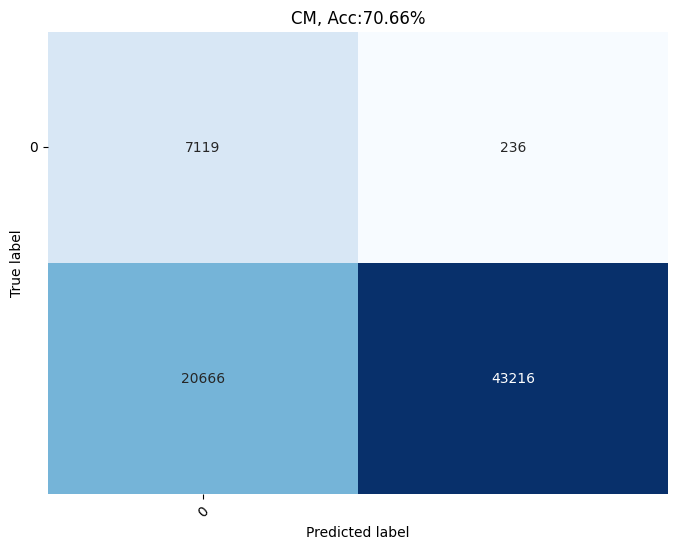

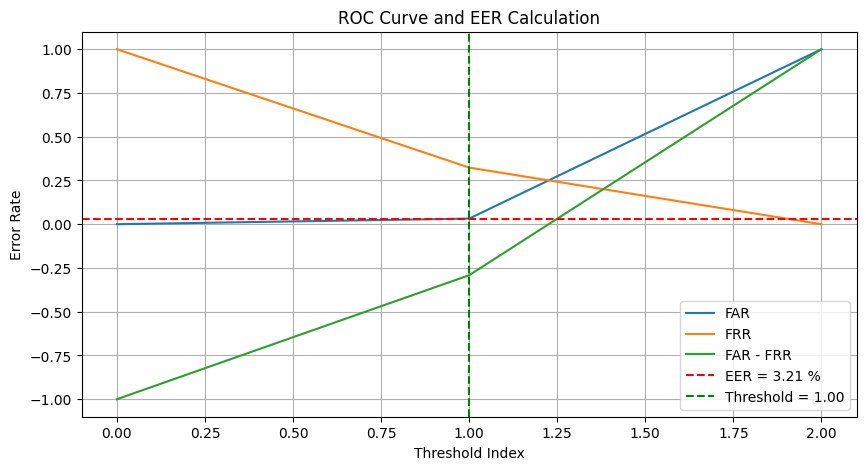

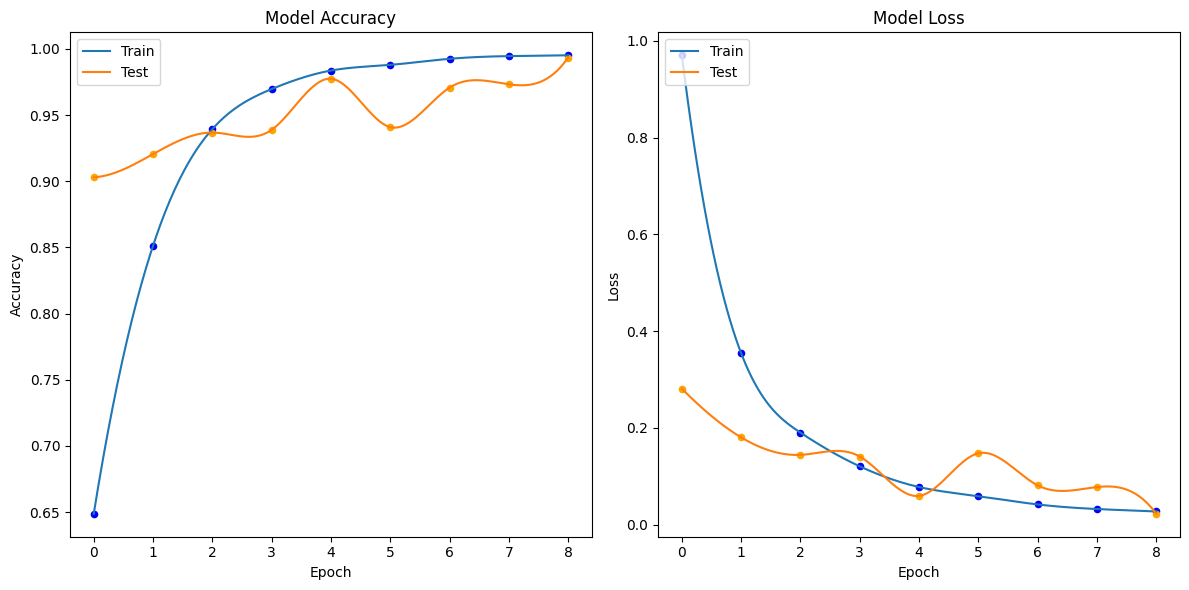

In [23]:
image_size = 70
patch_size = 70
num_classes = 1
num_layers = 1
d_model = 10
num_heads = 10
mlp_dim = 32
dropout_rate = 0.7

vit_model = create_vit_model(image_size, patch_size, num_classes, num_layers, d_model, num_heads, mlp_dim, dropout_rate)
vit_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics  = ['accuracy'])
callback = myCallback(patience=20)
history = vit_model.fit(xtrain, ytrain, 
          epochs=200,
          validation_data=[xvalid,yvalid],
          callbacks=callback)
ypred = predict_in_batches(vit_model, xtest)
plot_confusion_matrix(ytest, ypred)
plot_eer(ytest, ypred)
plot_training_history(history)

777/777 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


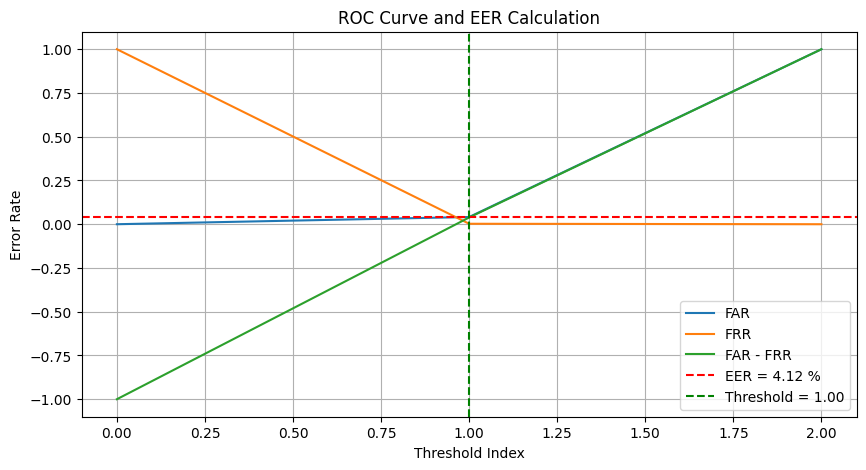

0.04120879120879121

In [24]:
plot_eer(yvalid, vit_model.predict(xvalid).reshape(-1).round())

## ViT ver1

In [ ]:
image_size = 70
patch_size = 14
num_classes = 1
num_layers = 30
d_model = 128
num_heads = 64
mlp_dim = 128
dropout_rate = 0.5

vit_model1 = create_vit_model(image_size, patch_size, num_classes, num_layers, d_model, num_heads, mlp_dim, dropout_rate)
vit_model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics  = ['accuracy'])
callback1 = myCallback(patience=20)
history1 = vit_model1.fit(xtrain, ytrain, 
          epochs=200,
          validation_data=[xvalid,yvalid],
          callbacks=callback1)
ypred1 = predict_in_batches(vit_model1, xtest)
plot_confusion_matrix(ytest, ypred1)
plot_eer(ytest, ypred1)

## ViT ver2

In [ ]:
image_size = 70
patch_size = 70
num_classes = 1
num_layers = 50
d_model = 128
num_heads = 64
mlp_dim = 128
dropout_rate = 0.5

vit_model2 = create_vit_model(image_size, patch_size, num_classes, num_layers, d_model, num_heads, mlp_dim, dropout_rate)
vit_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics  = ['accuracy'])
callback2 = myCallback(patience=10)
history2 = vit_model2.fit(xtrain, ytrain, 
          epochs=200,
          validation_data=[xvalid,yvalid],
          callbacks=callback2)
ypred2 = predict_in_batches(vit_model2, xtest)
plot_eer(ytest, ypred2)
plot_training_history(history2)

In [ ]:
acc = accuracy_score(ytest, ypred2.reshape(-1).round())
print('Accurancy:', acc*100)

In [ ]:
image_size = 70
patch_size = 70
num_classes = 1
num_layers = 6
d_model = 128
num_heads = 64
mlp_dim = 128
dropout_rate = 0.5

vit_model2 = create_vit_model_with_sinusoidal_encoding(image_size, patch_size, num_classes, num_layers, d_model, num_heads, mlp_dim, dropout_rate)
vit_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics  = ['accuracy'])
callback2 = myCallback(patience=10)
history2 = vit_model2.fit(xtrain, ytrain, 
          epochs=200,
          validation_data=[xvalid,yvalid],
          callbacks=callback2)
ypred2 = predict_in_batches(vit_model2, xtest)
plot_eer(ytest, ypred2)
plot_training_history(history2)

In [ ]:
vit_model2.summary()

## ViT ver3

In [ ]:
image_size = 70
patch_size = 70
num_classes = 1
num_layers = 2
d_model = 16
num_heads = 16
mlp_dim = 16
dropout_rate = 0.5

vit_model3 = create_vit_model(image_size, patch_size, num_classes, num_layers, d_model, num_heads, mlp_dim, dropout_rate)
vit_model3.compile(optimizer='adam', loss='binary_crossentropy', metrics  = ['accuracy'])
callback3 = myCallback(patience=20)
history3 = vit_model3.fit(xtrain, ytrain, 
          epochs=200,
          validation_data=[xvalid, yvalid],
          callbacks=callback3)
ypred3 =  predict_in_batches(vit_model3, xtest)
plot_confusion_matrix(ytest, ypred3)
plot_eer(ytest, ypred3)
plot_training_history(history3)

In [ ]:
image_size = 70
patch_size = 70
num_classes = 1
num_layers = 2
d_model = 16
num_heads = 16
mlp_dim = 16
dropout_rate = 0.5

vit_model3 = create_vit_model_with_sinusoidal_encoding(image_size, patch_size, num_classes, num_layers, d_model, num_heads, mlp_dim, dropout_rate)
vit_model3.compile(optimizer='adam', loss='binary_crossentropy', metrics  = ['accuracy'])
callback3 = myCallback(patience=20)
history3 = vit_model3.fit(xtrain, ytrain, 
          epochs=200,
          validation_data=[xvalid, yvalid],
          callbacks=callback3)
ypred3 =  predict_in_batches(vit_model3, xtest)
plot_eer(ytest, ypred3)
plot_training_history(history3)

In [ ]:
vit_model3.summary()

## ViT ver4

In [ ]:
image_size = 70
patch_size = 70
num_classes = 1
num_layers = 2
d_model = 3
num_heads = 3
mlp_dim = 3
dropout_rate = 0.5

vit_model4 = create_vit_model(image_size, patch_size, num_classes, num_layers, d_model, num_heads, mlp_dim, dropout_rate)
vit_model4.compile(optimizer='adam', loss='binary_crossentropy', metrics  = ['accuracy'])
callback4 = myCallback(patience=20)
history4 = vit_model4.fit(xtrain, ytrain, 
          epochs=200,
          validation_data=[xtest,ytest],
          callbacks=callback4)
ypred4 = vit_model4.predict(xtest)
plot_eer(ytest, ypred4)
plot_training_history(history4)

In [ ]:
vit_model4.summary()

## ViT ver 5

In [ ]:
image_size = 100
patch_size = 100
num_classes = 1
num_layers = 1
num_heads = 2
mlp_dim = 16
dropout_rate = 0.5

vit_model5 = create_vit_model(image_size, patch_size, num_classes, num_layers, d_model, num_heads, mlp_dim, dropout_rate)
vit_model5.compile(optimizer='adam', loss='binary_crossentropy', metrics  = ['accuracy'])
callback5 = myCallback(patience=10)
history5 = vit_model5.fit(xtrain, ytrain, 
          epochs=200,
          validation_data=[xtest,ytest],
          callbacks=callback5)
ypred5 = vit_model5.predict(xtest)
plot_eer(ytest, ypred5)
plot_training_history(history5)
vit_model5.summary()

## NASNet

In [ ]:
from tensorflow.keras import backend as K

K.clear_session()


343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/200


I0000 00:00:1728316432.570112      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


794/794 ━━━━━━━━━━━━━━━━━━━━ 819s 541ms/step - accuracy: 0.9182 - loss: 0.5930 - val_accuracy: 0.8974 - val_loss: 1.6351
Epoch 2/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 133s 168ms/step - accuracy: 0.9926 - loss: 0.0301 - val_accuracy: 0.8974 - val_loss: 1.6351
Epoch 3/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 142s 167ms/step - accuracy: 0.9984 - loss: 0.0073 - val_accuracy: 0.9766 - val_loss: 0.3661
Epoch 4/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 132s 167ms/step - accuracy: 0.9985 - loss: 0.0051 - val_accuracy: 0.8930 - val_loss: 1.1461
Epoch 5/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 133s 168ms/step - accuracy: 0.9966 - loss: 0.0095 - val_accuracy: 0.9836 - val_loss: 0.2527
Epoch 6/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 137s 172ms/step - accuracy: 0.9991 - loss: 0.0066 - val_accuracy: 0.8854 - val_loss: 1.7463
Epoch 7/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 132s 166ms/step - accuracy: 0.9986 - loss: 0.0074 - val_accuracy: 0.9872 - val_loss: 0.1758
Epoch 8/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 132s 166ms/step - accuracy: 0.9991 - los

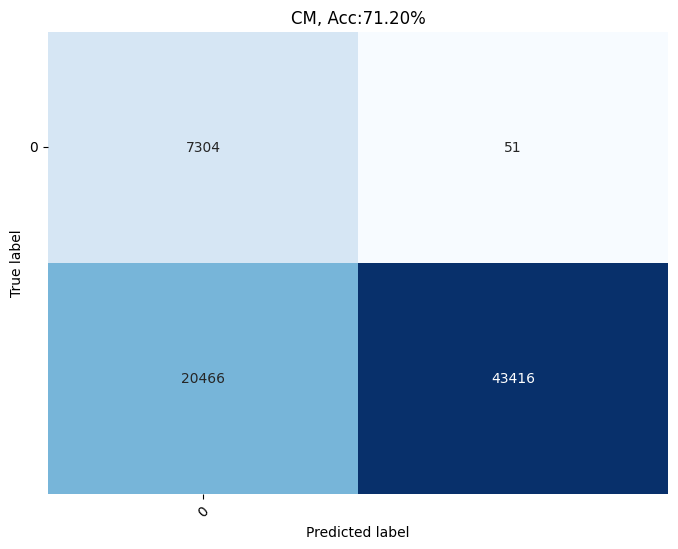

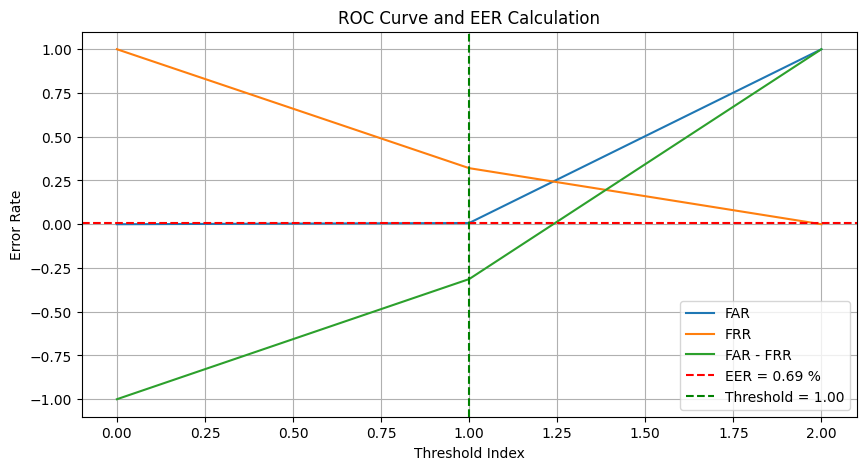

777/777 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step


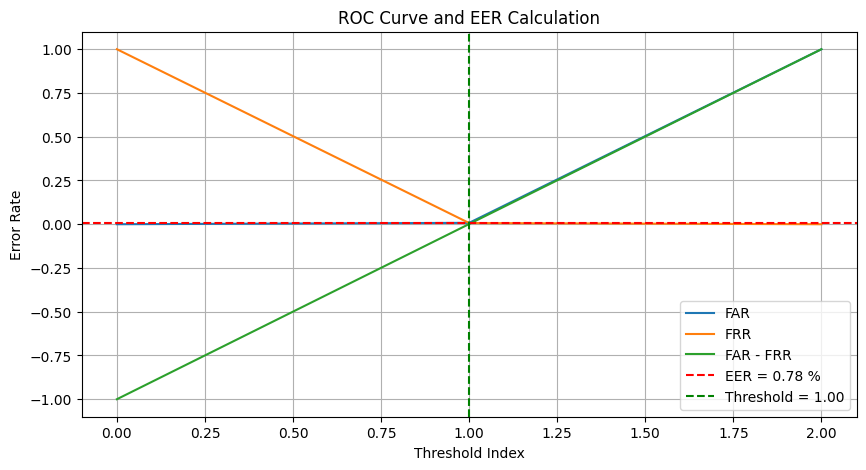

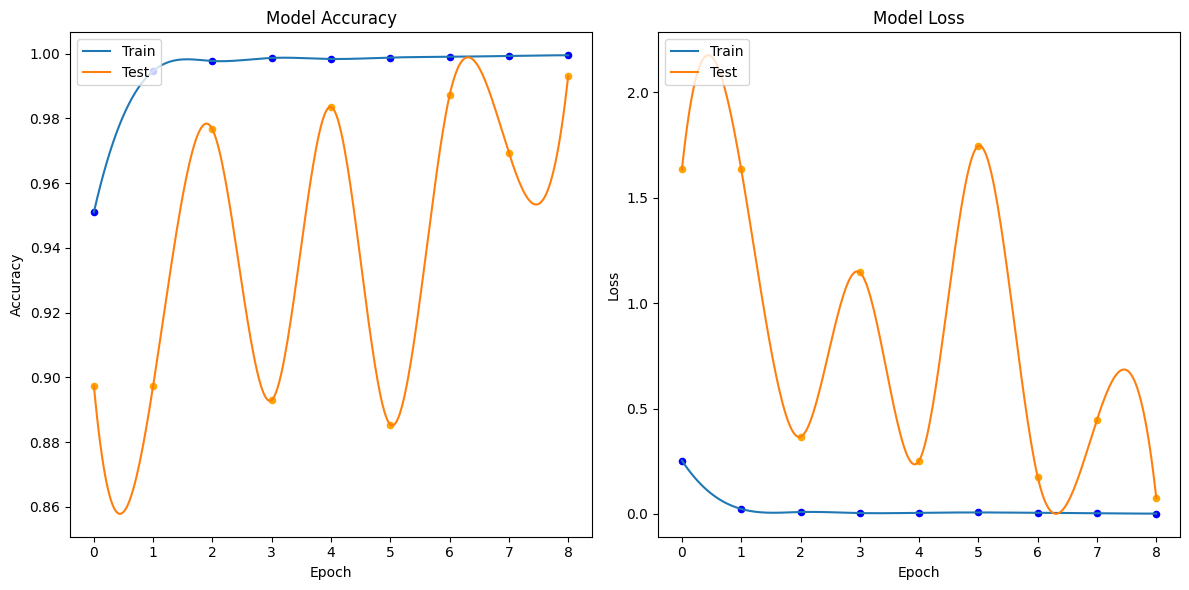

In [20]:
NASNet_base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(70, 70, 3)) 


x = NASNet_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
NASNet_model = Model(inputs=NASNet_base_model.input, outputs=predictions)

for layer in NASNet_base_model.layers:
    layer.trainable = True

NASNet_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
callback6 = myCallback(patience=20, max_acc=0.99)
history6 = NASNet_model.fit(xtrain, ytrain, 
          epochs=200,
          validation_data=[xvalid,yvalid],
          callbacks=callback6)
ypred6 = predict_in_batches(NASNet_model, xtest)
plot_confusion_matrix(ytest, ypred6)
plot_eer(ytest, ypred6)
plot_eer(yvalid, NASNet_model.predict(xvalid).reshape(-1).round())
plot_training_history(history6)

# Resnet152

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 446s 284ms/step - accuracy: 0.9224 - loss: 0.1955 - val_accuracy: 0.8974 - val_loss: 0.3955
Epoch 2/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 83s 104ms/step - accuracy: 0.9847 - loss: 0.0435 - val_accuracy: 0.9667 - val_loss: 0.1094
Epoch 3/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 83s 104ms/step - accuracy: 0.9920 - loss: 0.0216 - val_accuracy: 0.9485 - val_loss: 0.2448
Epoch 4/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - accuracy: 0.9940 - loss: 0.0185 - val_accuracy: 0.9041 - val_loss: 0.3628
Epoch 5/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 83s 104ms/step - accuracy: 0.9934 - loss: 0.0207 - val_accuracy: 0.9535 - val_loss: 0.2954
Epoch 6/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - accuracy: 0.9958 - loss: 0.0140 - val_accuracy: 0.9666 - val_loss: 0.0835
Epoch 7/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - accuracy: 0.9972 - loss: 0.0079 - val_accuracy: 0.9527 - val_loss: 0.1309
Epoch 8/200
794/794 ━━

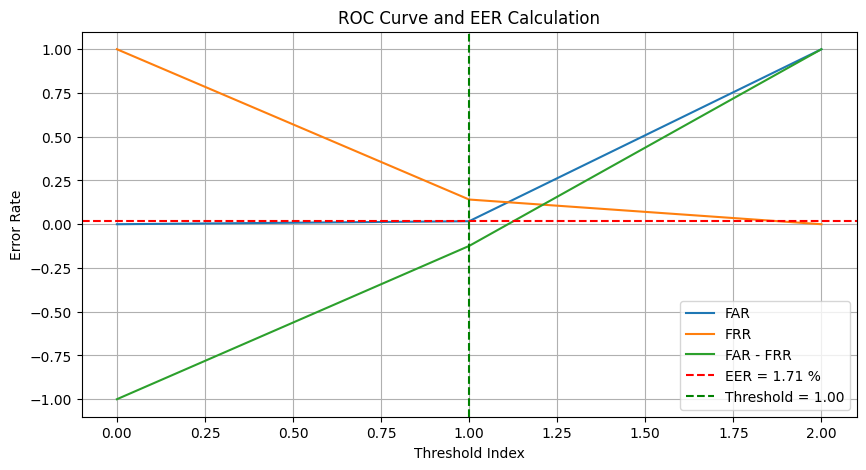

777/777 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step


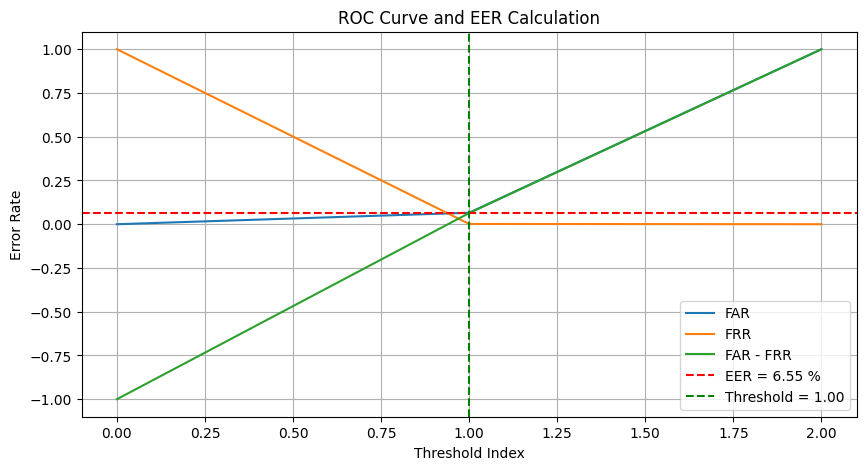

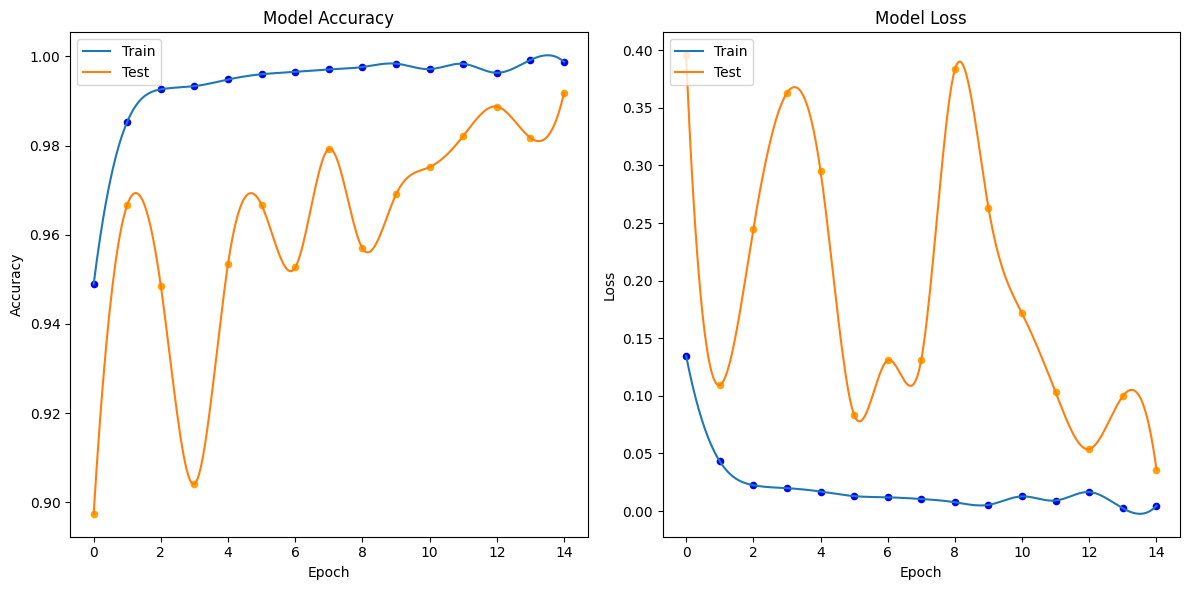

In [18]:
base_model = tf.keras.applications.ResNet152(
    include_top=False, 
    weights='imagenet', 
    input_shape=(70,70,3)
)

# Freeze the convolutional base
base_model.trainable = True

# Create new model on top
inputs = tf.keras.Input(shape=(70,70,3))
x = base_model(inputs, training=False)  # Make sure to use base_model in inference mode
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = LayerNormalization()(x)  
x = tf.keras.layers.Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

ResNet152_model = models.Model(inputs, outputs)

# Biên dịch mô hình
ResNet152_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
callback9 = myCallback(patience=10)
history9 = ResNet152_model.fit(xtrain, ytrain, 
          epochs=200,
          validation_data=[xvalid,yvalid],
          callbacks=callback9)
ypred9 = predict_in_batches(ResNet152_model, xtest)
plot_eer(ytest, ypred9)
plot_eer(yvalid, ResNet152_model.predict(xvalid).reshape(-1).round())
plot_training_history(history9)
# ResNet101_model.summary()

In [ ]:
plot_confusion_matrix(ytest, ypred9)

In [ ]:
from tensorflow.keras import backend as K

K.clear_session()

# EfficientNetB0

Epoch 1/200


I0000 00:00:1728553568.421331    1744 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


794/794 ━━━━━━━━━━━━━━━━━━━━ 239s 147ms/step - accuracy: 0.9461 - loss: 0.1379 - val_accuracy: 0.8913 - val_loss: 0.3937
Epoch 2/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.9968 - loss: 0.0134 - val_accuracy: 0.9661 - val_loss: 0.1327
Epoch 3/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.9965 - loss: 0.0145 - val_accuracy: 0.9789 - val_loss: 0.1163
Epoch 4/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9983 - loss: 0.0043 - val_accuracy: 0.8991 - val_loss: 0.6386
Epoch 5/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.9988 - loss: 0.0048 - val_accuracy: 0.8975 - val_loss: 0.7661
Epoch 6/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9976 - loss: 0.0089 - val_accuracy: 0.8208 - val_loss: 2.3843
Epoch 7/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.9986 - loss: 0.0065 - val_accuracy: 0.9946 - val_loss: 0.0276
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
625/625 ━━

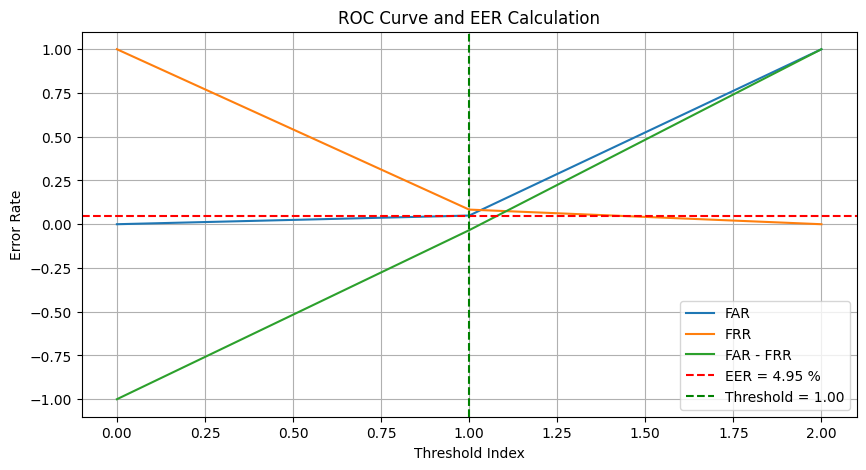

777/777 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step


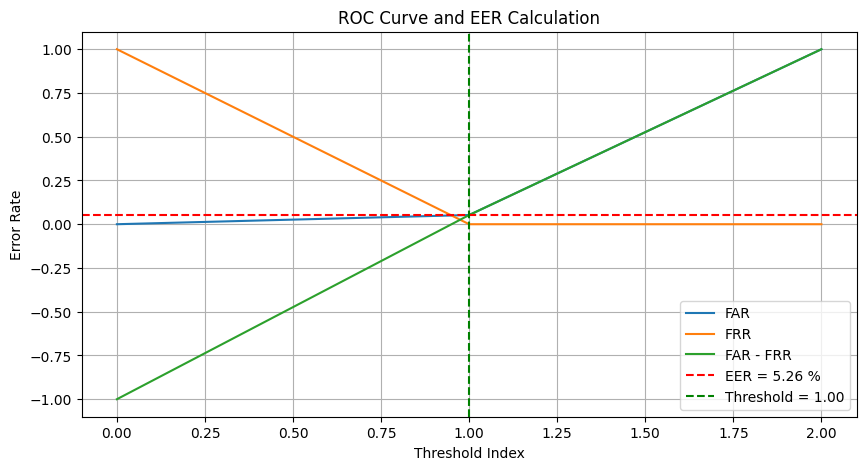

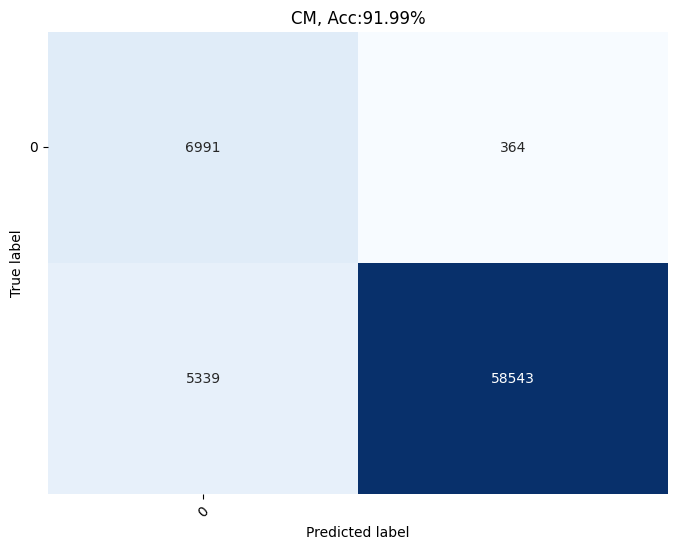

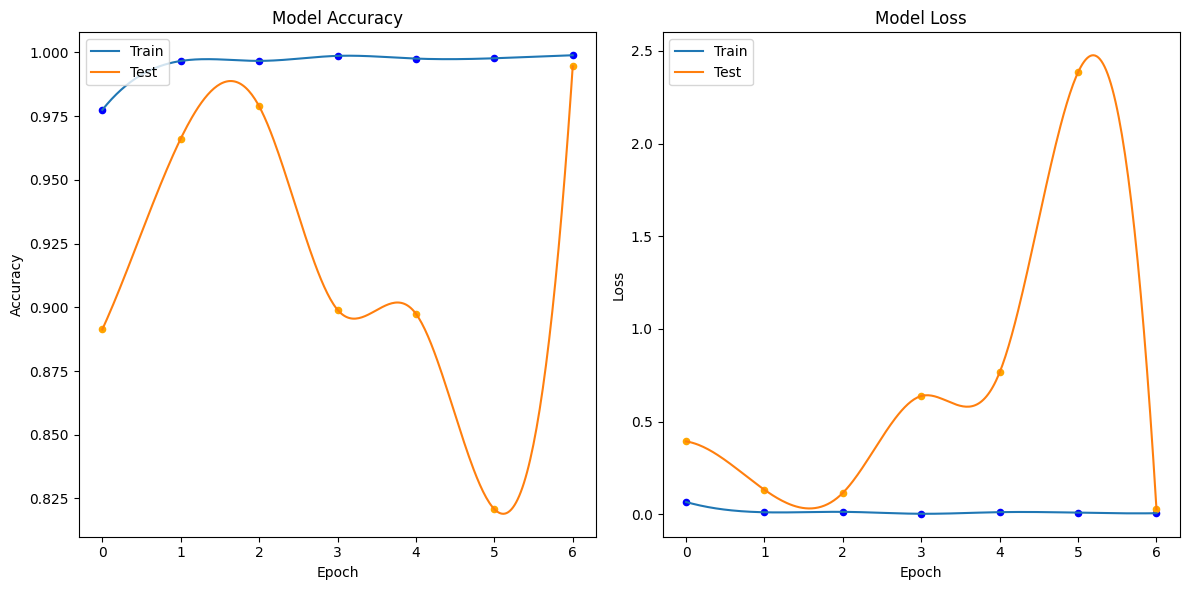

In [16]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
# Tải mô hình EfficientNetB0 với trọng số được đào tạo trên ImageNet
EfficientNetB0_base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(70, 70, 3))

# Thêm các lớp tùy chỉnh
x = EfficientNetB0_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)  # Thêm lớp Dropout để giảm hiện tượng overfitting
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Định nghĩa mô hình hoàn chỉnh
EfficientNetB0_model = Model(inputs=EfficientNetB0_base_model.input, outputs=predictions)

# Đóng băng các lớp của mô hình cơ sở
for layer in EfficientNetB0_base_model.layers:
    layer.trainable = True

# Biên dịch mô hình
EfficientNetB0_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
callback11 = myCallback(patience=20)
history11 = EfficientNetB0_model.fit(xtrain, ytrain, 
          epochs=200,
          validation_data=[xvalid,yvalid],
          callbacks=callback11)
ypred11 = predict_in_batches(EfficientNetB0_model, xtest)
plot_eer(ytest, ypred11)
plot_eer(yvalid, EfficientNetB0_model.predict(xvalid).reshape(-1).round())
plot_confusion_matrix(ytest, ypred11)
plot_training_history(history11)
# EfficientNetB0_model.summary()

In [21]:
xtrain0 = xtrain[:,:,:,0]
xvalid0 = xvalid[:,:,:,0]
xtest0 = xtest[:,:,:,0]

xtrain1 = xtrain[:,:,:,1]
xvalid1 = xvalid[:,:,:,1]
xtest1 = xtest[:,:,:,1]

xtrain2 = xtrain[:,:,:,2]
xvalid2 = xvalid[:,:,:,2]
xtest2 = xtest[:,:,:,2]

## 1 Feature

Epoch 1/200
 21/794 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7406 - loss: 0.5927 

I0000 00:00:1728555130.681078    2178 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


794/794 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.9231 - loss: 0.1977 - val_accuracy: 0.8974 - val_loss: 1.6307
Epoch 2/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9895 - loss: 0.0350 - val_accuracy: 0.9770 - val_loss: 0.0563
Epoch 3/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9933 - loss: 0.0220 - val_accuracy: 0.9839 - val_loss: 0.0753
Epoch 4/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9935 - loss: 0.0208 - val_accuracy: 0.9455 - val_loss: 0.2002
Epoch 5/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9948 - loss: 0.0158 - val_accuracy: 0.9767 - val_loss: 0.0697
Epoch 6/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9966 - loss: 0.0106 - val_accuracy: 0.9777 - val_loss: 0.1298
Epoch 7/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9957 - loss: 0.0125 - val_accuracy: 0.9526 - val_loss: 0.2032
Epoch 8/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9976 - loss: 0.0078 - val_accuracy: 0.92

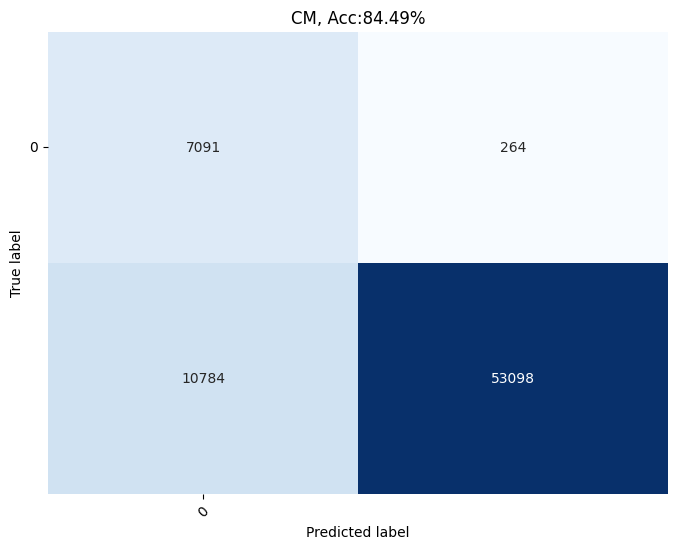

777/777 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


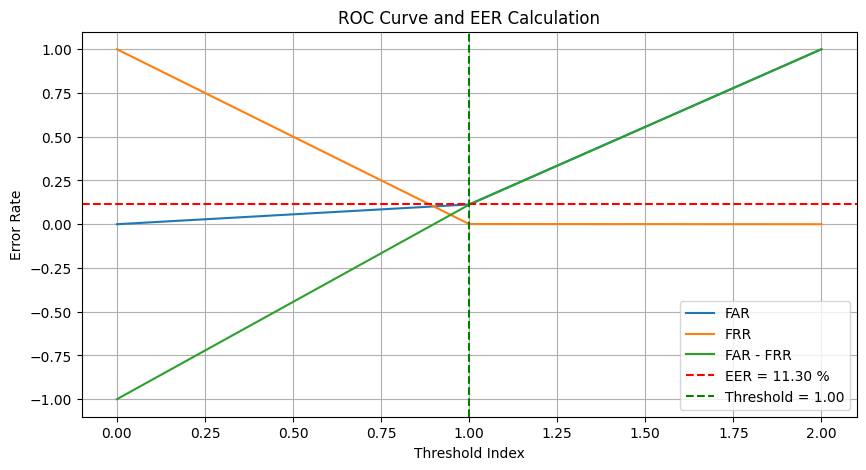

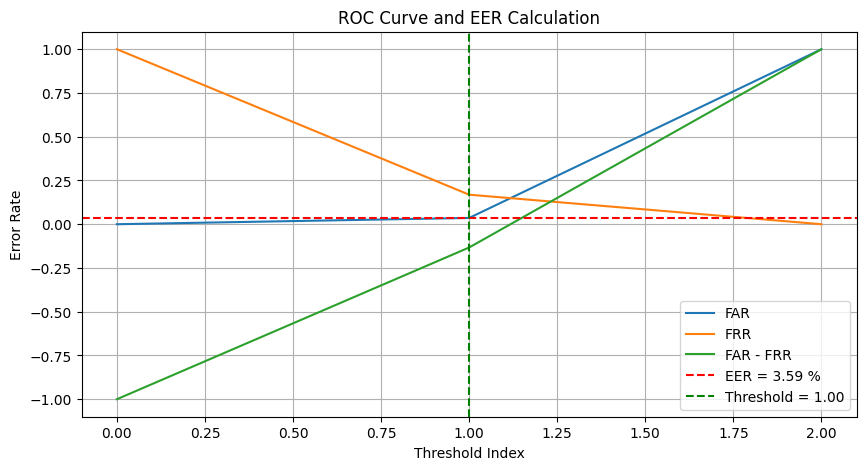

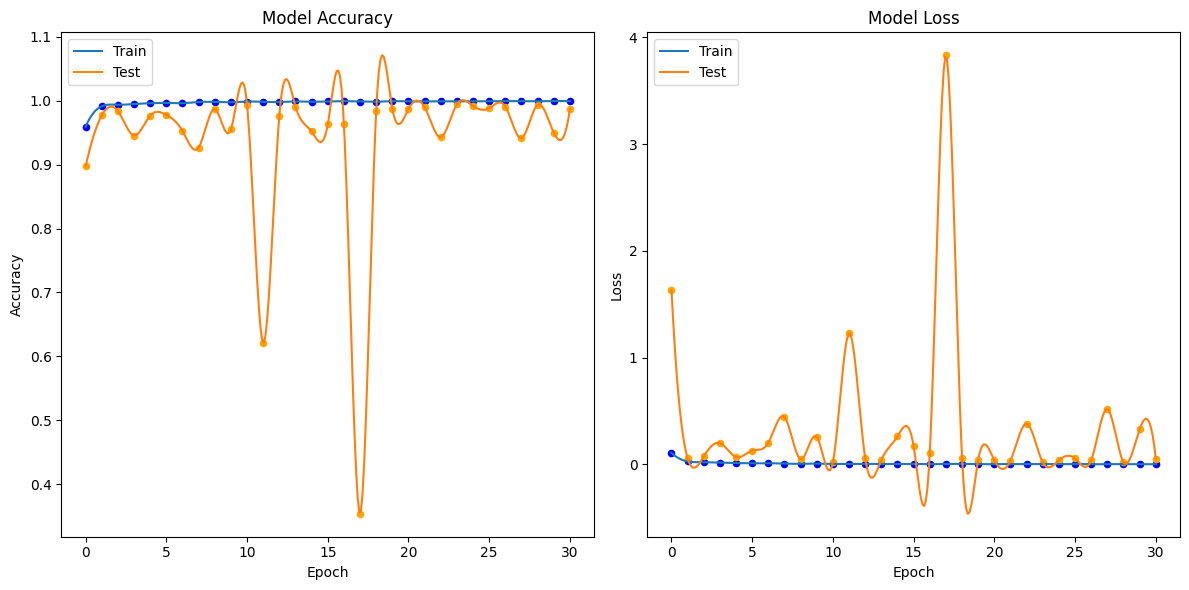

In [22]:
# Specify input shape and number of classes
input_shape = (70,70,1)
num_classes = 1

# Build and compile the model
# with strategy.scope():
restnest_model = build_resnest(input_shape, num_classes, dim=128)
restnest_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
callback_0 = myCallback(patience=20, max_acc=1)
history_0 = restnest_model.fit(xtrain0, ytrain, 
          epochs=200,
          validation_data=[xvalid0,yvalid],
          callbacks=callback_0)
ypred_0 = predict_in_batches(restnest_model, xtest0)
plot_confusion_matrix(ytest, ypred_0)
plot_eer(yvalid, restnest_model.predict(xvalid0).reshape(-1).round())
plot_eer(ytest, ypred_0)
plot_training_history(history_0)

Epoch 1/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9026 - loss: 0.2516 - val_accuracy: 0.9038 - val_loss: 0.2091
Epoch 2/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9419 - loss: 0.1284 - val_accuracy: 0.5440 - val_loss: 1.5610
Epoch 3/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9595 - loss: 0.0962 - val_accuracy: 0.8996 - val_loss: 0.4126
Epoch 4/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9686 - loss: 0.0768 - val_accuracy: 0.9005 - val_loss: 0.4652
Epoch 5/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9743 - loss: 0.0635 - val_accuracy: 0.5003 - val_loss: 2.7433
Epoch 6/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9797 - loss: 0.0518 - val_accuracy: 0.9502 - val_loss: 0.1264
Epoch 7/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9833 - loss: 0.0445 - val_accuracy: 0.9040 - val_loss: 0.2778
Epoch 8/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9845 - loss: 0.0409 - val_ac

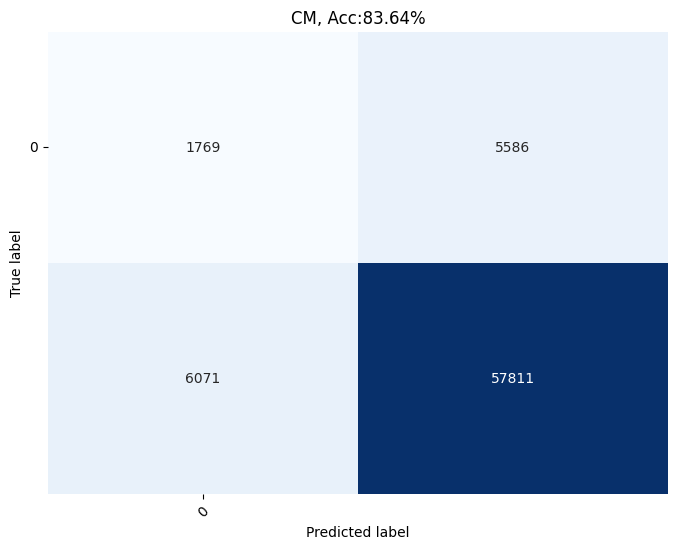

777/777 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


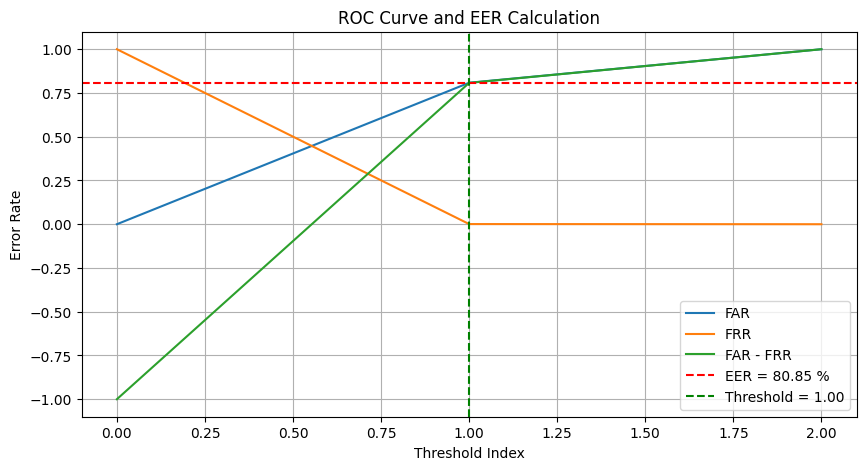

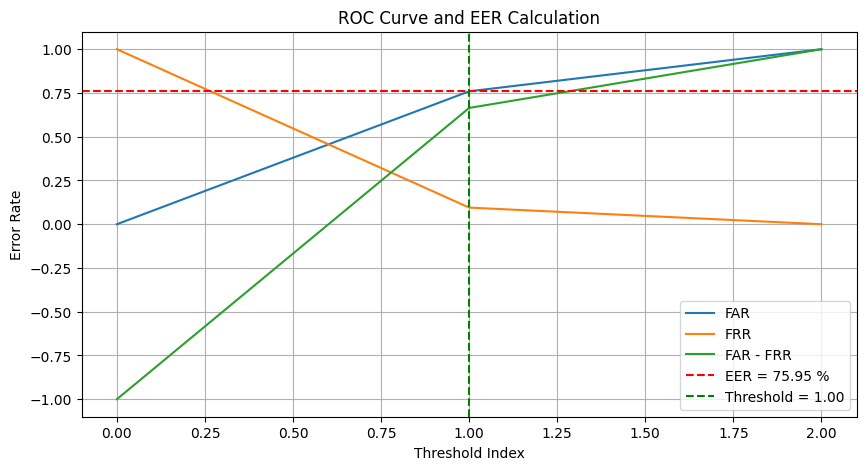

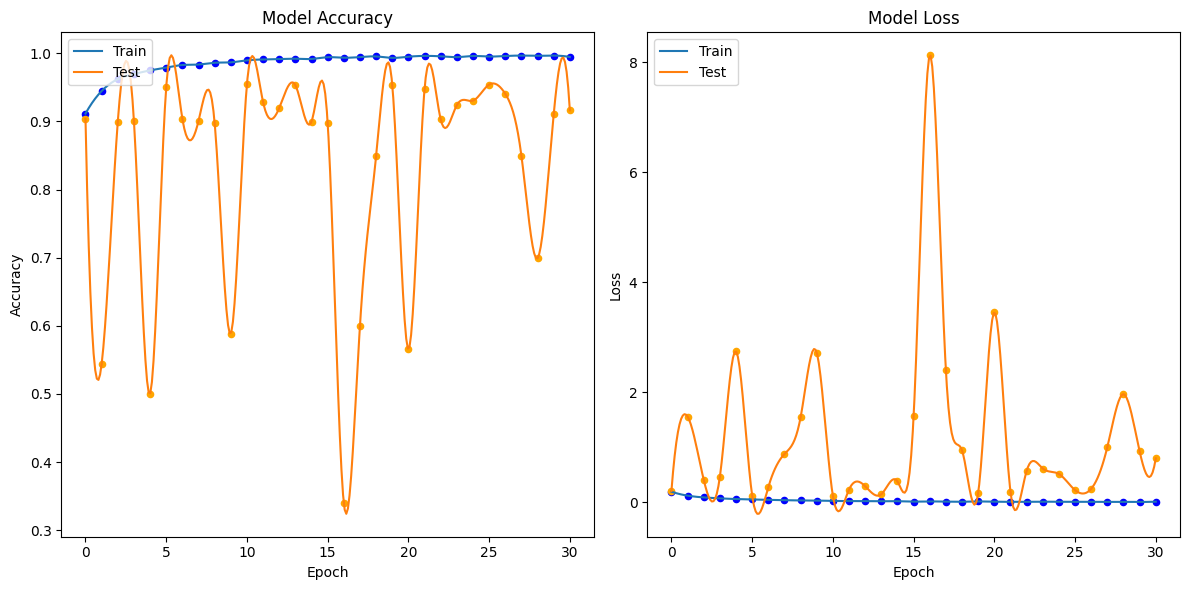

In [23]:
# Specify input shape and number of classes
input_shape = (70,70,1)
num_classes = 1

# Build and compile the model
# with strategy.scope():
restnest_model = build_resnest(input_shape, num_classes, dim=128)
restnest_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
callback_0 = myCallback(patience=20, max_acc=1)
history_0 = restnest_model.fit(xtrain1, ytrain, 
          epochs=200,
          validation_data=[xvalid1,yvalid],
          callbacks=callback_0)
ypred_0 = predict_in_batches(restnest_model, xtest1)
plot_confusion_matrix(ytest, ypred_0)
plot_eer(yvalid, restnest_model.predict(xvalid1).reshape(-1).round())
plot_eer(ytest, ypred_0)
plot_training_history(history_0)

Epoch 1/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8824 - loss: 0.3283 - val_accuracy: 0.8985 - val_loss: 0.2555
Epoch 2/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9167 - loss: 0.2080 - val_accuracy: 0.8992 - val_loss: 0.2770
Epoch 3/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9257 - loss: 0.1858 - val_accuracy: 0.9071 - val_loss: 0.2318
Epoch 4/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9408 - loss: 0.1496 - val_accuracy: 0.8965 - val_loss: 0.2308
Epoch 5/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9481 - loss: 0.1344 - val_accuracy: 0.9094 - val_loss: 0.2176
Epoch 6/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9572 - loss: 0.1153 - val_accuracy: 0.9158 - val_loss: 0.2095
Epoch 7/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9602 - loss: 0.1018 - val_accuracy: 0.8794 - val_loss: 0.2902
Epoch 8/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9682 - loss: 0.0879 - val_ac

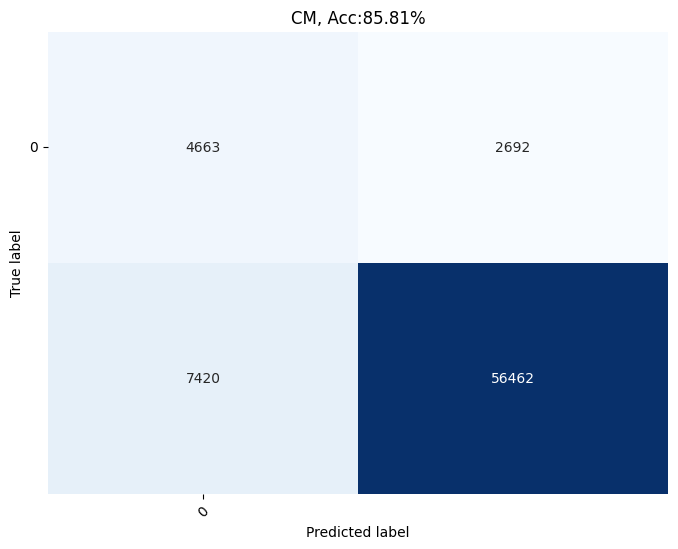

777/777 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


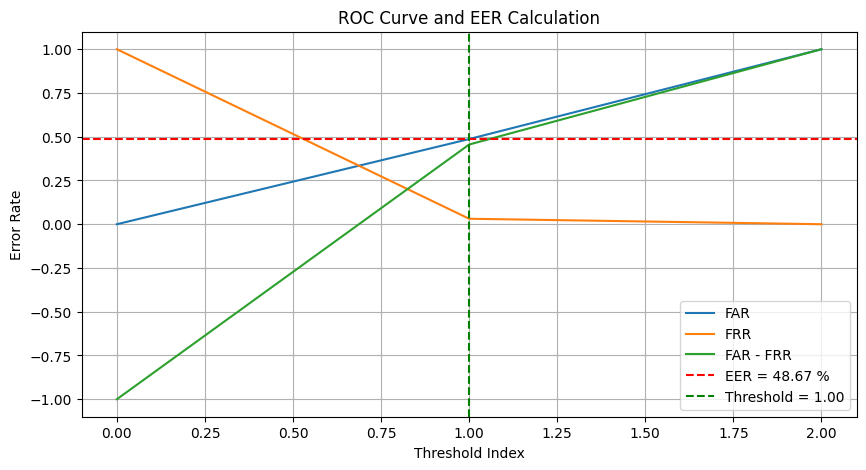

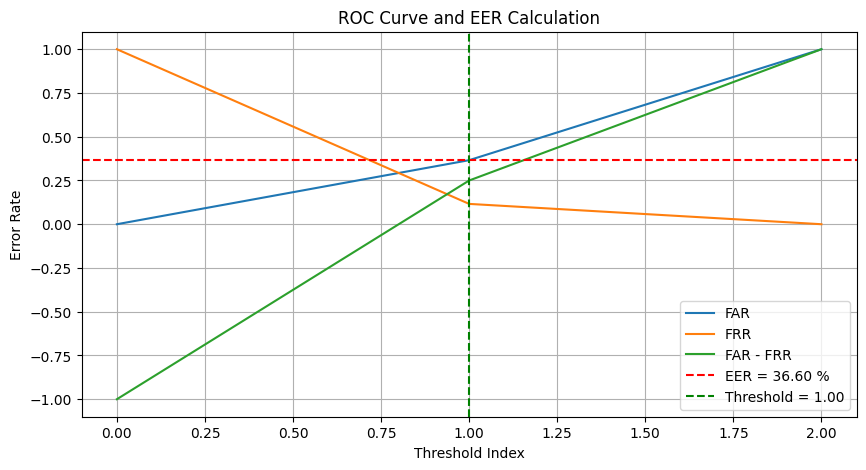

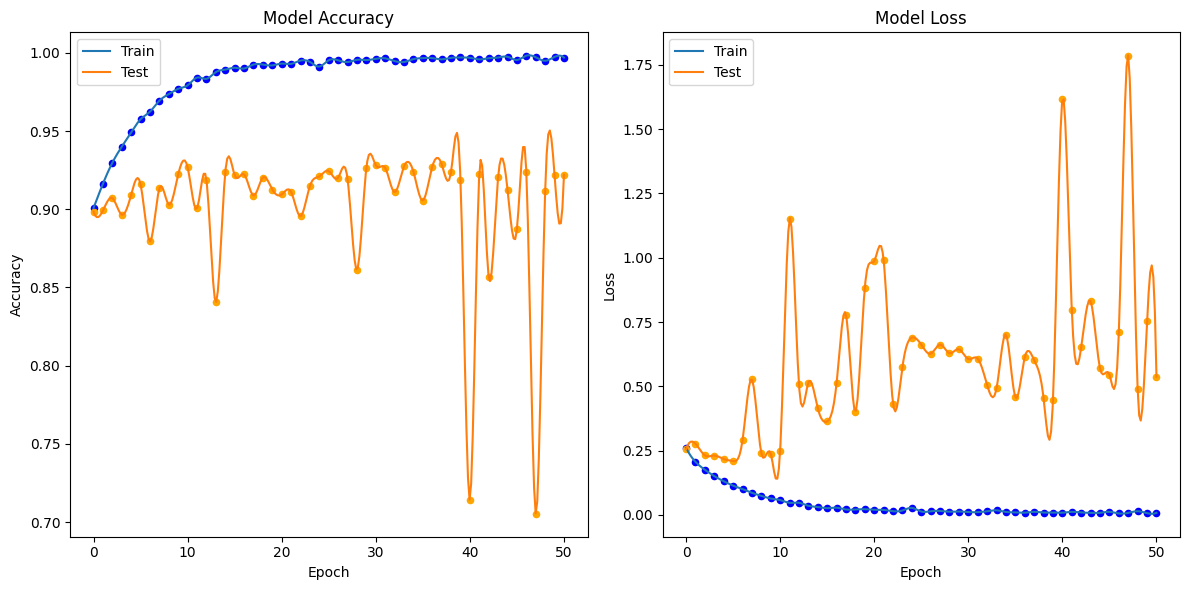

In [24]:
# Specify input shape and number of classes
input_shape = (70,70,1)
num_classes = 1

# Build and compile the model
# with strategy.scope():
restnest_model = build_resnest(input_shape, num_classes, dim=128)
restnest_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
callback_0 = myCallback(patience=20, max_acc=1)
history_0 = restnest_model.fit(xtrain2, ytrain, 
          epochs=200,
          validation_data=[xvalid2,yvalid],
          callbacks=callback_0)
ypred_0 = predict_in_batches(restnest_model, xtest2)
plot_confusion_matrix(ytest, ypred_0)
plot_eer(yvalid, restnest_model.predict(xvalid2).reshape(-1).round())
plot_eer(ytest, ypred_0)
plot_training_history(history_0)

# 2 Feature

In [16]:
xtrain01 = xtrain[:,:,:,0:2]
xvalid01 = xvalid[:,:,:,0:2]
xtest01 = xtest[:,:,:,0:2]

xtrain12 = xtrain[:,:,:,1:]
xvalid12 = xvalid[:,:,:,1:]
xtest12 = xtest[:,:,:,1:]

xtrain20 = np.stack([xtrain[:,:,:,0], xtrain[:,:,:,2]], axis=-1)
xvalid20 = np.stack([xvalid[:,:,:,0], xvalid[:,:,:,2]], axis=-1)
xtest20 = np.stack([xtest[:,:,:,0], xtest[:,:,:,2]], axis=-1)

Epoch 1/200
 21/794 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7151 - loss: 0.5971 

I0000 00:00:1728556165.210883    4633 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


794/794 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.9276 - loss: 0.1939 - val_accuracy: 0.9933 - val_loss: 0.0266
Epoch 2/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9954 - loss: 0.0188 - val_accuracy: 0.9698 - val_loss: 0.0747
Epoch 3/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9979 - loss: 0.0087 - val_accuracy: 0.9106 - val_loss: 0.4753
Epoch 4/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9991 - loss: 0.0059 - val_accuracy: 0.9774 - val_loss: 0.0614
Epoch 5/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9986 - loss: 0.0057 - val_accuracy: 0.9973 - val_loss: 0.0078
Epoch 6/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9985 - loss: 0.0047 - val_accuracy: 0.9969 - val_loss: 0.0085
Epoch 7/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9986 - loss: 0.0042 - val_accuracy: 0.9989 - val_loss: 0.0042
Epoch 8/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 9.1786e-04 - val_accuracy: 

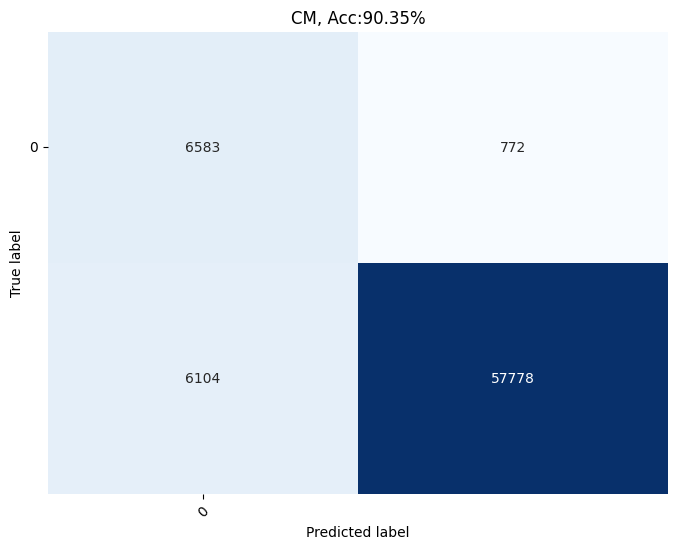

777/777 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


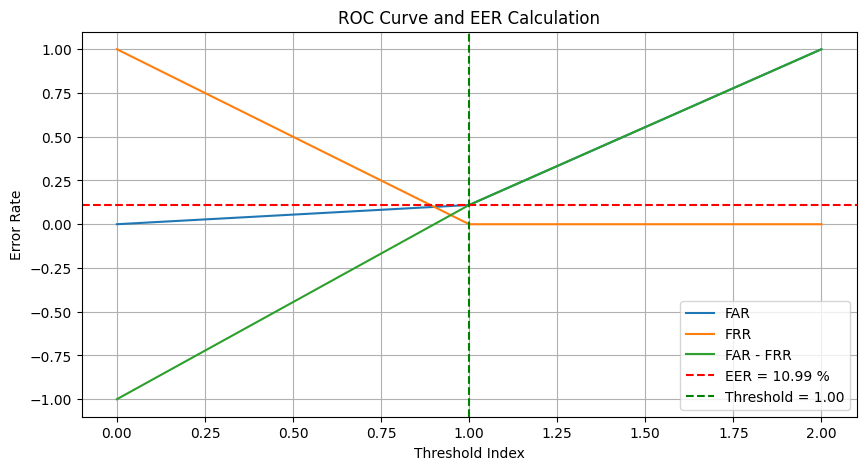

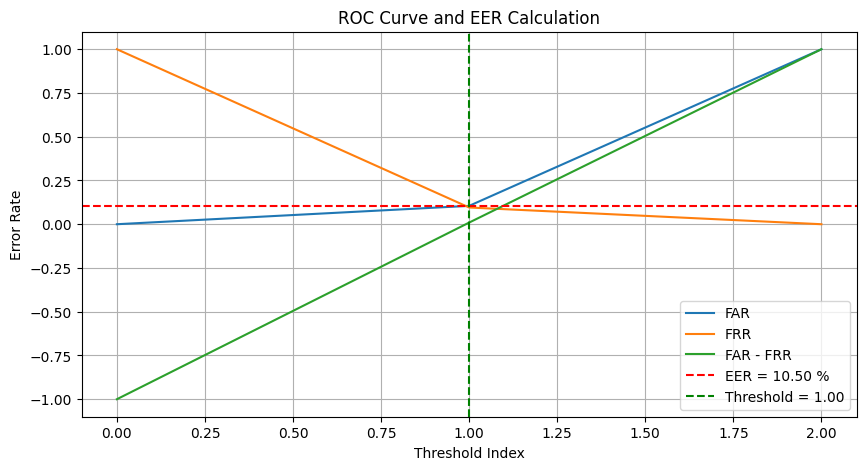

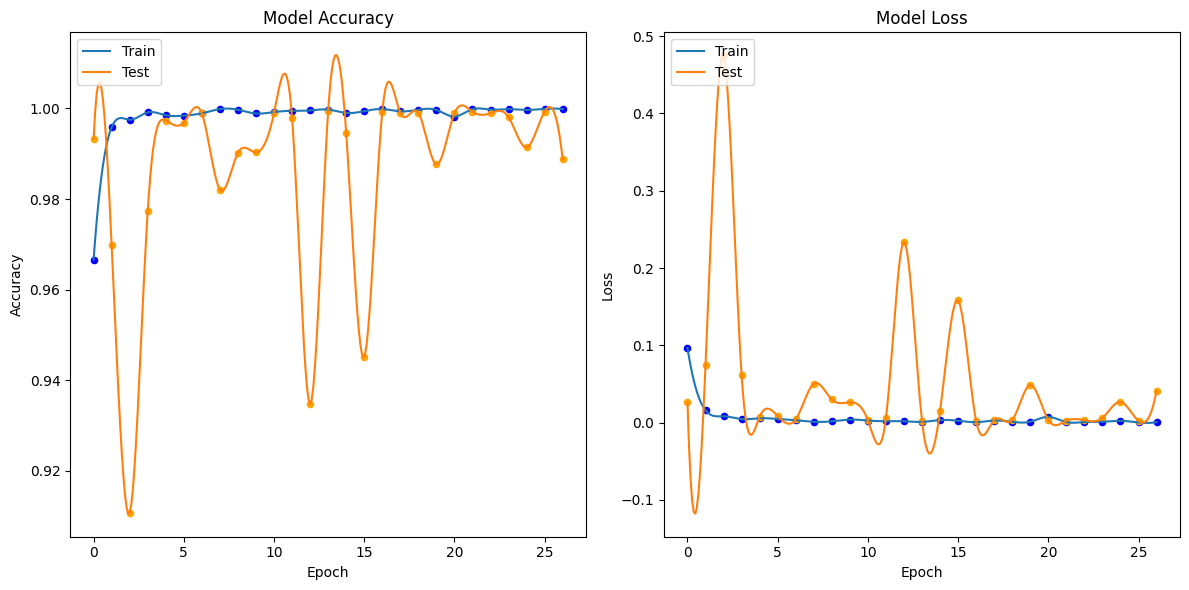

In [20]:
# Specify input shape and number of classes
input_shape = (70,70,2)
num_classes = 1

# Build and compile the model
# with strategy.scope():
restnest_model = build_resnest(input_shape, num_classes, dim=128)
restnest_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
callback_0 = myCallback(patience=20, max_acc=1)
history_0 = restnest_model.fit(xtrain01, ytrain, 
          epochs=200,
          validation_data=[xvalid01,yvalid],
          callbacks=callback_0)
ypred_0 = predict_in_batches(restnest_model, xtest01)
plot_confusion_matrix(ytest, ypred_0)
plot_eer(yvalid, restnest_model.predict(xvalid01).reshape(-1).round())
plot_eer(ytest, ypred_0)
plot_training_history(history_0)

Epoch 1/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.9087 - loss: 0.2417 - val_accuracy: 0.9201 - val_loss: 0.1958
Epoch 2/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9739 - loss: 0.0754 - val_accuracy: 0.9842 - val_loss: 0.0430
Epoch 3/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9881 - loss: 0.0361 - val_accuracy: 0.9866 - val_loss: 0.0403
Epoch 4/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9898 - loss: 0.0308 - val_accuracy: 0.9861 - val_loss: 0.0409
Epoch 5/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9943 - loss: 0.0181 - val_accuracy: 0.9922 - val_loss: 0.0241
Epoch 6/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9959 - loss: 0.0127 - val_accuracy: 0.9650 - val_loss: 0.0976
Epoch 7/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9959 - loss: 0.0129 - val_accuracy: 0.9337 - val_loss: 0.1856
Epoch 8/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9972 - loss: 0.0086 - val_ac

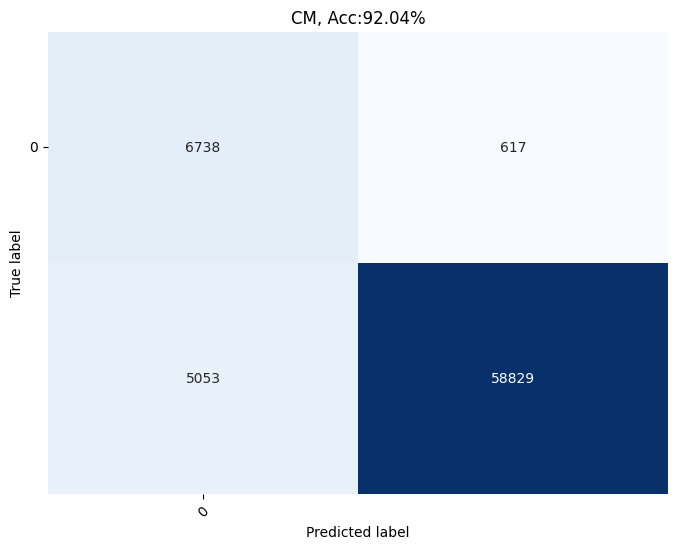

777/777 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


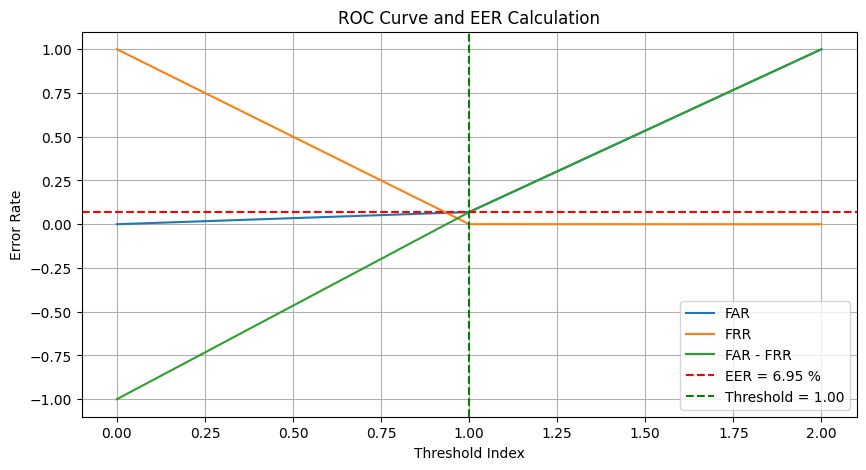

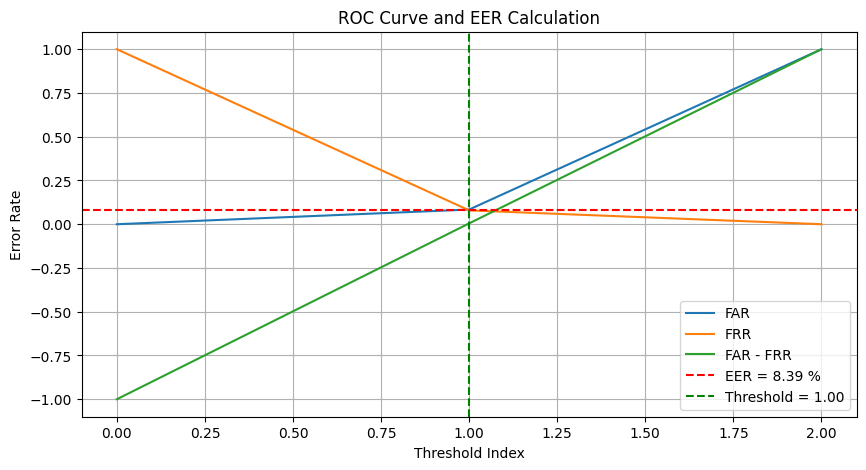

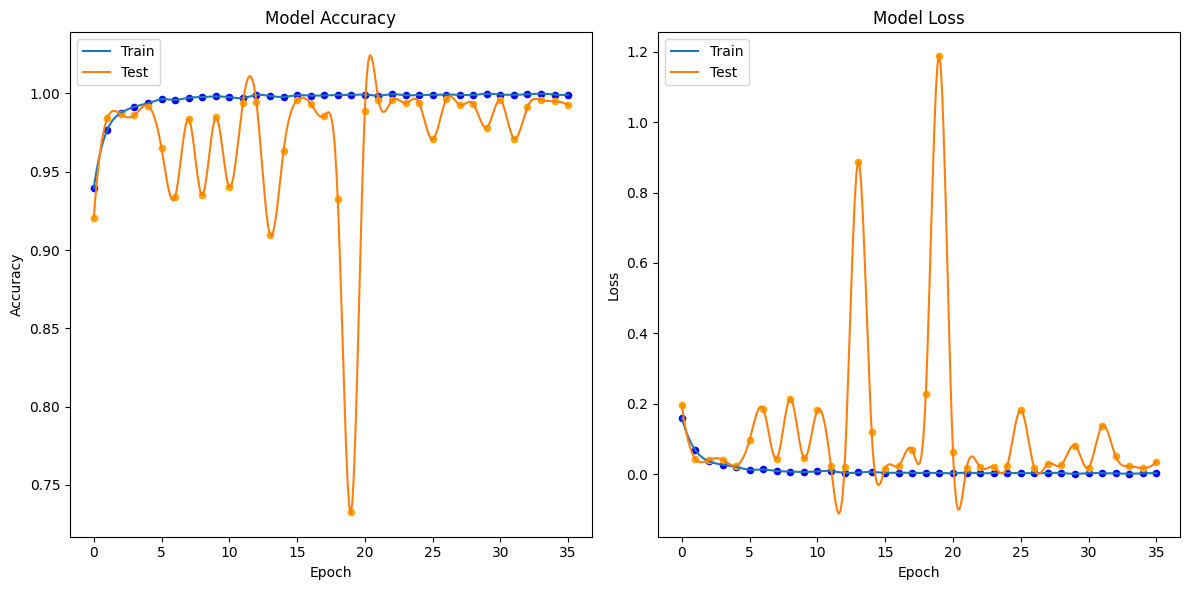

In [21]:
# Specify input shape and number of classes
input_shape = (70,70,2)
num_classes = 1

# Build and compile the model
# with strategy.scope():
restnest_model = build_resnest(input_shape, num_classes, dim=128)
restnest_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
callback_0 = myCallback(patience=20, max_acc=1)
history_0 = restnest_model.fit(xtrain12, ytrain, 
          epochs=200,
          validation_data=[xvalid12,yvalid],
          callbacks=callback_0)
ypred_0 = predict_in_batches(restnest_model, xtest12)
plot_confusion_matrix(ytest, ypred_0)
plot_eer(yvalid, restnest_model.predict(xvalid12).reshape(-1).round())
plot_eer(ytest, ypred_0)
plot_training_history(history_0)

In [17]:
# Specify input shape and number of classes
input_shape = (70,70,2)
num_classes = 1

# Build and compile the model
# with strategy.scope():
restnest_model = build_resnest(input_shape, num_classes, dim=128)
restnest_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
callback_0 = myCallback(patience=20, max_acc=1)
history_0 = restnest_model.fit(xtrain20, ytrain, 
          epochs=200,
          validation_data=[xvalid20,yvalid],
          callbacks=callback_0)
ypred_0 = predict_in_batches(restnest_model, xtest20)
plot_confusion_matrix(ytest, ypred_0)
plot_eer(yvalid, restnest_model.predict(xvalid20).reshape(-1).round())
plot_eer(ytest, ypred_0)
plot_training_history(history_0)

Epoch 1/200
 21/794 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6347 - loss: 0.6579 

I0000 00:00:1728556908.605949    5945 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


794/794 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.8985 - loss: 0.2641 - val_accuracy: 0.9050 - val_loss: 0.2257
Epoch 2/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9789 - loss: 0.0649 - val_accuracy: 0.9621 - val_loss: 0.0910
Epoch 3/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9901 - loss: 0.0329 - val_accuracy: 0.9670 - val_loss: 0.0981
Epoch 4/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9957 - loss: 0.0178 - val_accuracy: 0.9725 - val_loss: 0.0735
Epoch 5/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9940 - loss: 0.0185 - val_accuracy: 0.9397 - val_loss: 0.2404
Epoch 6/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9969 - loss: 0.0102 - val_accuracy: 0.9674 - val_loss: 0.1028
Epoch 7/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9975 - loss: 0.0086 - val_accuracy: 0.9832 - val_loss: 0.0526
Epoch 8/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9962 - loss: 0.0117 - val_accuracy: 0.98

NameError: name 'predict_in_batches' is not defined

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


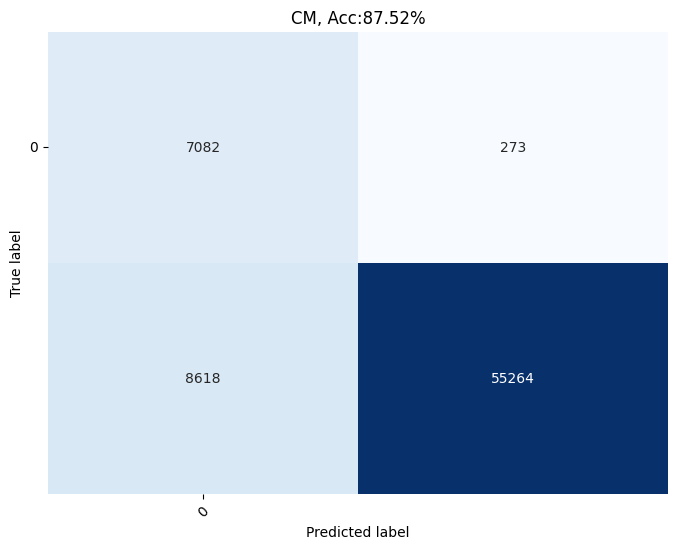

777/777 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


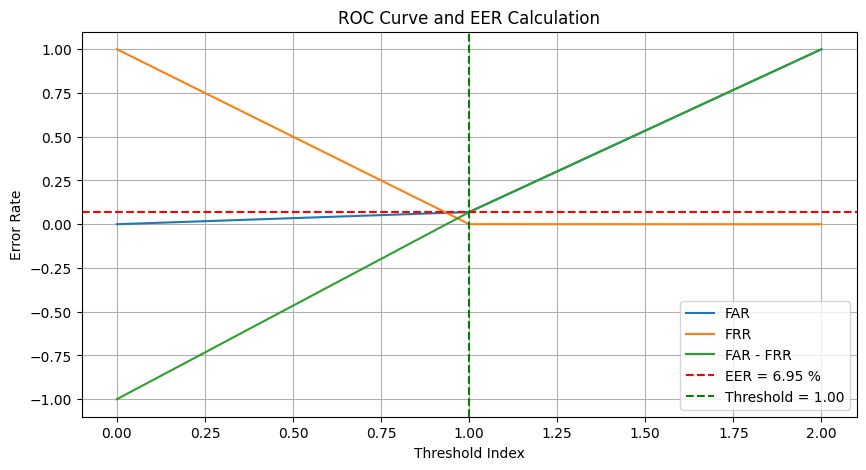

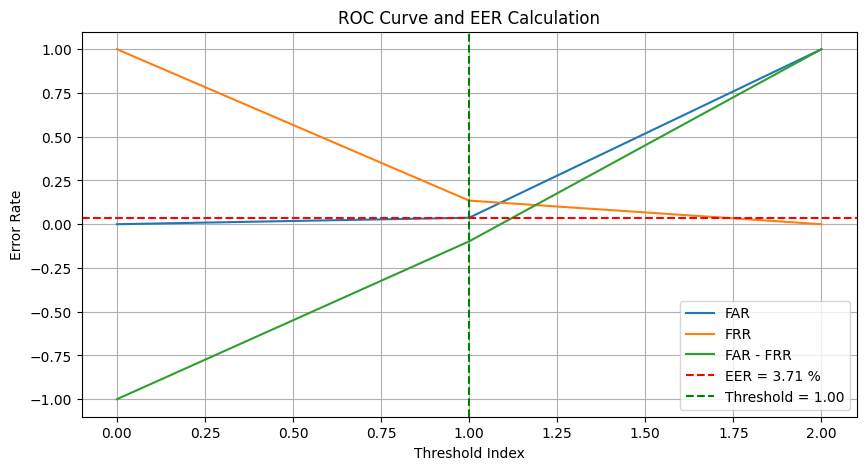

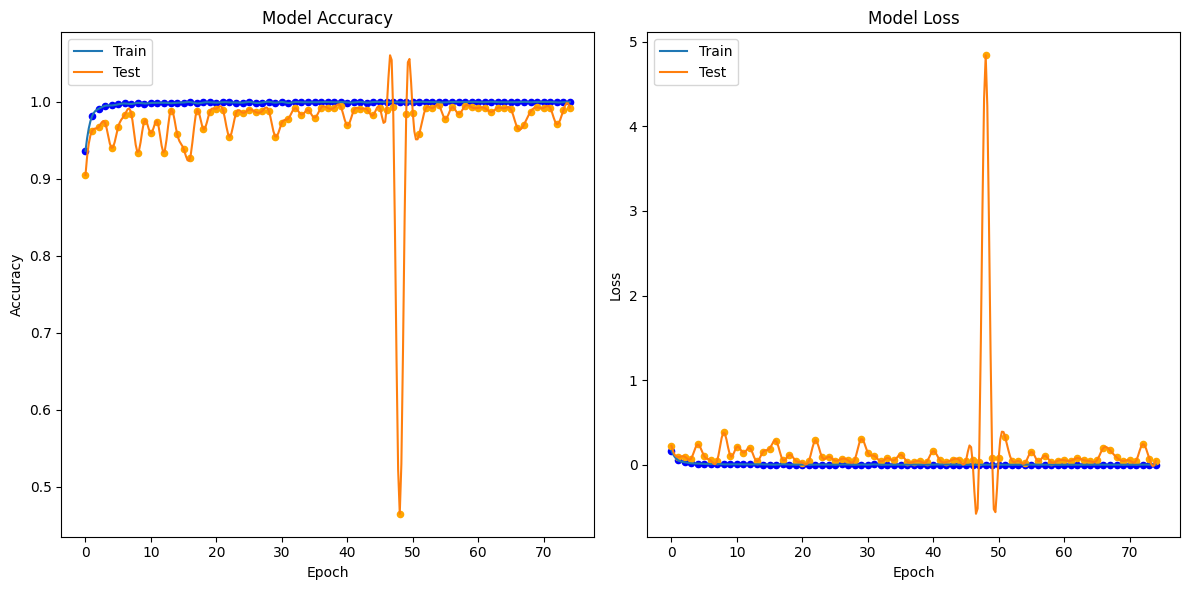

In [20]:
ypred_0 = predict_in_batches(restnest_model, xtest20)
plot_confusion_matrix(ytest, ypred_0)
plot_eer(yvalid, restnest_model.predict(xvalid20).reshape(-1).round())
plot_eer(ytest, ypred_0)
plot_training_history(history_0)